# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook - good example how to add TabPFN
- https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Metric - good guide on creating custom metric in Keras
- https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/410139 - overall notes about similar competitions

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [x] Submition Error When calculating results.
- [x] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [x] Solved problem with NaNs in metric -> min/max vals less than 1 more than 0, as in competrion calculator
- [x] loss: 0.0000e+00. Why ? Is it OK ? -> Yes it is okey. https://discuss.tensorflow.org/t/tfdf-custom-loss/2223
- [ ] Research wheather it is possible to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [ ] Ensemble Results by some model:
    - Currently Simple Manual Weights, which may be more optimal. Need to make some grid and choose the best.
    - I use Mean for Each CV Branch, may-be also grant some threshs or weights
    - [x] Refactored each Model Estimation to result into Train/Valid/Test Frames
- [ ] Cutoffs
    - https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c
    - Find Lower/Upper Bounds which maximises competition metric
- [ ] May be try several CVs
- [ ] May be play with uplift to lessen features input
    

In [1]:
SUBMITION = False

## Install TabPFN offline

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [2]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

import joblib
import os
import shutil

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [4]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [5]:
mining_columns: list = [i for i in dataset_df.columns if i not in ["Id","Class"]]

def compute_basic_stats(columns: list, df: pd.DataFrame) -> pd.DataFrame:
    
    out: dict = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

# Train
basic_stats_1 = compute_basic_stats(columns=mining_columns, df=dataset_df)

basic_stats_1.to_pickle('/kaggle/working/basic_stats_1.pickle')

# Inference
# basic_stats_1 = pd.read_pickle('/kaggle/working/basic_stats_1.pickle')

  0%|          | 0/56 [00:00<?, ?it/s]

In [6]:
basic_stats_1

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU,253,0.2,float64,0.26,0.005518,161.355315,9.034721,1.8029,5.55868
BC,259,0.0,float64,0.16,1.2299,1463.693448,65.166943,8.053012,5.724924
AF,599,0.0,float64,0.3,192.59328,28688.18766,2300.322717,3502.013221,5.900177
EH,127,0.0,float64,0.18,0.003042,42.569748,1.847499,0.305107,5.900177
AM,605,0.0,float64,0.24,3.177522,630.51823,69.728226,38.968552,5.900177
FD,337,0.0,float64,0.13,0.29685,1578.654237,64.754262,6.930086,5.900177
DI,571,0.0,float64,0.26,60.23247,1049.168078,86.084419,146.972099,5.900177
FR,435,0.0,float64,0.1,0.49706,1244.22702,50.181948,3.533905,5.900177
AB,217,0.0,float64,0.28,0.081187,6.161666,0.468388,0.477149,6.017012
CF,586,0.0,float64,0.11,0.510888,200.967526,13.571133,11.241064,6.192265


* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [7]:
WoE_Columns = ['DU', 'BC', 'AF', 'EH', 'AM', 'FD', 'DI', 'FR', 'AB', 'CF', 'BZ', 'FE', 'AX', 'BR',
               'GB', 'AY', 'FC', 'FS', 'CC', 'GH', 'DV', 'DY', 'EE', 'GE', 'AH', 'DN', 'EP', 'EU',
               'EG', 'FI', 'DH', 'GF', 'GI', 'DE', 'DA', 'CW', 'CU', 'AZ', 'CL', 'CH', 'BD', 'BN',
               'DL', 'CS', 'FL', 'GL', 'CB', 'DF', 'BP', 'EB', 'AR', 'CD', 'EL', 'CR', 'BQ']

In [8]:
def preprocess_train(train: pd.DataFrame, numeric_features: list, save_path: str) -> None:
    woes = dict()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train[i], y=train['Class'])
        woes[i] = tmp_woe
    
    # Save WoE
    _ = joblib.dump(value=woes, filename=save_path)
    print('Saved features: ', save_path)
    
    return None

def preprocess_inference(train: pd.DataFrame, test: pd.DataFrame, 
                         numeric_features: list,
                         stats: pd.DataFrame, save_path: str) -> (pd.DataFrame, pd.DataFrame, list):
    info = dict()
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    woes = joblib.load(save_path)
    
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        train_out[i + '_WoE'] = woes[i].transform(X=train_out[i])
        test_out[i + '_WoE'] = woes[i].transform(X=test_out[i])
        out_features.append(i + '_WoE')
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features


# Only for Train
_ = preprocess_train(train=dataset_df, numeric_features=WoE_Columns, save_path='/kaggle/working/WoE.pickle')

# For Train & Inference
train_out,test_out,features = preprocess_inference(train=dataset_df, 
                                                   test=dataset_test_df,
                                                   stats=basic_stats_1, 
                                                   numeric_features=WoE_Columns,
                                                   save_path='/kaggle/working/WoE.pickle')

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Saved features:  /kaggle/working/WoE.pickle


WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [9]:
class BalancedLogLoss(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_log_loss', **kwargs):
        super(BalancedLogLoss, self).__init__(name=name, **kwargs)
        self.log_loss = self.add_weight(name='log_loss', initializer='zeros')

    def update_state(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None):
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Correct Values
        min_val = 1e-15
        max_val = 0.999999999999999
        
        y_pred = tf.math.minimum(y_pred, [max_val])
        y_pred = tf.math.maximum(y_pred, [min_val])
        
        log_y_pred_1 = tf.reshape(K.log(y_pred),[-1,1])
        log_y_pred_0 = tf.reshape(K.log(1-y_pred),[-1,1])

        y_1 = tf.reshape(y_true,[1,-1])
        y_0 = 1-y_1

        logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
        logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

        av_logloss = (logloss_1+logloss_0)/2
        
        self.log_loss.assign_add(av_logloss)

    def result(self):
        return self.log_loss

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.log_loss.assign(0.)

def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()


from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin

class TFDF_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = tfdf.keras.RandomForestModel, label = "Class"):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(), model_compile_kwargs = dict()):

        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X['Class'])):
                print('##### Fold',i+1)

                # Fetch values corresponding to the index 
                train_df = X.iloc[train_index]
                valid_df = X.iloc[valid_index]
                valid_ids = valid_df.index.values
                train_ids = train_df.index.values

                # Select only feature columns for training.
                train_df = train_df[self.features+[self.label]]
                valid_df = valid_df[self.features+[self.label]]

                # We need to convert the datatset from Pandas format (pd.DataFrame)
                train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=self.label)
                valid_tf = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=self.label)

                # Define & Train the model and metrics
                model = self.model_obj(**model_kwargs)
                model.compile(**model_compile_kwargs) 
                model.fit(x=train_tf, class_weight=class_weight)

                # Store the model
                self.models[i] = model

                # Predict Values
                self.X_summary.loc[train_ids, i] = model.predict(x=train_tf).flatten()
                self.valid_summary.loc[valid_ids, 0] = model.predict(x=valid_tf).flatten()

                # Evaluate and store the metrics in respective dicts
                evaluation = model.evaluate(x=train_tf,return_dict=True)
                train_metric = evaluation["balanced_log_loss"]

                evaluation = model.evaluate(x=valid_tf,return_dict=True)
                val_metric = evaluation["balanced_log_loss"]

                # Plot Results
                plot_train_logs(model)

                balanced_logloss_train[i] = train_metric
                balanced_logloss_val[i] = val_metric

                print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")

        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(self.metrics['train']).mean():.4f} std: {pd.Series(self.metrics['train']).std():.4f}")
        print(f"\nValidation mean: {pd.Series(self.metrics['val']).mean():.4f} std: {pd.Series(self.metrics['val']).std():.4f}")
        
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_splits = len(self.models)
        X_tf = tfdf.keras.pd_dataframe_to_tf_dataset(X[self.features]) # Technial, to conert frame to tensor for makind a predictions using tensor framework
        X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            X_summary[i] = model.predict(x=X_tf).flatten() 
        
        return X_summary
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            model.save(filepath=f'{save_path}/models/{fold}')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = tf.keras.models.load_model(f'{save_path}/models/{i}',
                                              custom_objects={"BalancedLogLoss": BalancedLogLoss})
            
        return self

```python
# Test
my_splitter = StratifiedKFold(n_splits=2,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# load
CV_Ensemble_1_load = TFDF_CV_Ensemble()

CV_Ensemble_1_load = CV_Ensemble_1_load.load(save_path='/kaggle/working/RF/1')


# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

train_summary_rf_1 = CV_Ensemble_1_load.X_summary
valid_summary_rf_1 = CV_Ensemble_1_load.valid_summary
test_summary_rf_1 = CV_Ensemble_1_load.predict(X=test_out)
model_rf_1 = CV_Ensemble_1_load.models
metrics_rf_1 = CV_Ensemble_1_load.metrics
```

```python
# Let's try to find Cutoffs organically
train_summary_rf_1_mean = train_summary_rf_1.mean(axis=1)
train_summary_rf_1_mean.name = 'Pred'

tmp = pd.concat([train_summary_rf_1_mean, train_out['Class']], axis=1).sort_index(ascending=True)

tmp['Pred_Bins'] = pd.qcut(x=tmp['Pred'],q=100)
tmp = tmp.groupby('Pred_Bins')['Class'].agg({'sum','count'})
tmp['count_cumsum'] = tmp['count'].cumsum()
tmp['sum_cumsum'] = tmp['sum'].cumsum()

tmp['bads_rate'] = tmp['sum_cumsum']/tmp['count_cumsum']

tmp['perc_sum'] = [*range(1,101)]

tmp
```

# RandomForestModel

##### Fold 1
Use /tmp/tmpzx46lhd5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:10.124137. Found 514 examples.
Training model...
Model trained in 0:00:00.831257
Compiling model...


[INFO 23-07-29 11:40:01.0312 UTC kernel.cc:1242] Loading model from path /tmp/tmpzx46lhd5/model/ with prefix 33440e101baa49e0
[INFO 23-07-29 11:40:01.1812 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33286 node(s), and 113 input feature(s).
[INFO 23-07-29 11:40:01.1813 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:40:01.1814 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 434ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3276


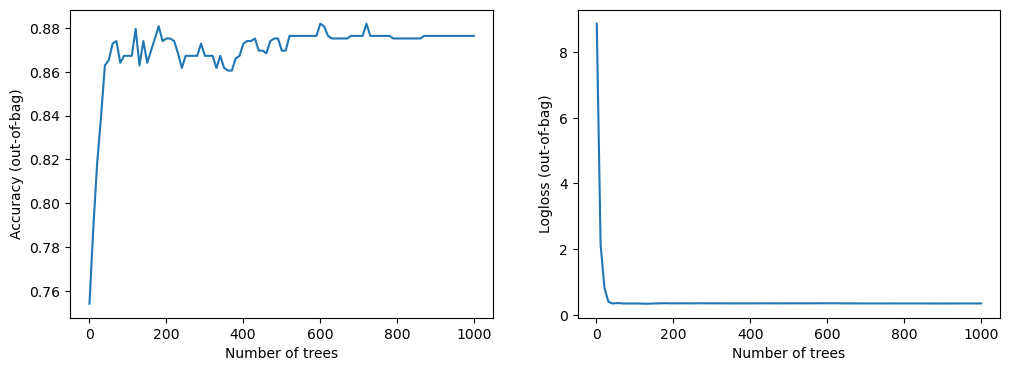


Train: 0.1731 Validation: 0.3276
##### Fold 2
Use /tmp/tmpi4sp05nc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.174969. Found 514 examples.
Training model...
Model trained in 0:00:00.756674
Compiling model...


[INFO 23-07-29 11:40:11.5053 UTC kernel.cc:1242] Loading model from path /tmp/tmpi4sp05nc/model/ with prefix 8810a6bb93bb428e
[INFO 23-07-29 11:40:11.6489 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33396 node(s), and 113 input feature(s).
[INFO 23-07-29 11:40:11.6490 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:40:11.6491 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 400ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9515 - balanced_log_loss: 0.2998


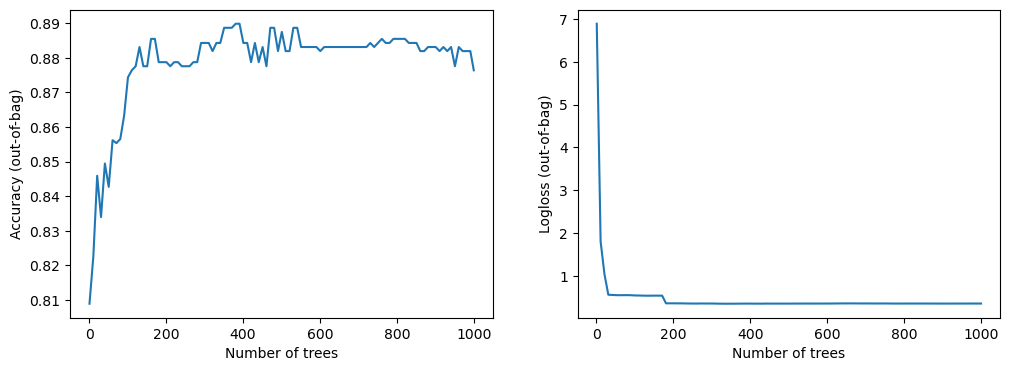


Train: 0.5067 Validation: 0.2998
##### Fold 3
Use /tmp/tmp8mxhn94d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.280371. Found 514 examples.
Training model...
Model trained in 0:00:00.746370
Compiling model...


[INFO 23-07-29 11:40:18.9833 UTC kernel.cc:1242] Loading model from path /tmp/tmp8mxhn94d/model/ with prefix 99de5d6f0c9a42f9
[INFO 23-07-29 11:40:19.1210 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33376 node(s), and 113 input feature(s).
[INFO 23-07-29 11:40:19.1213 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 391ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3269


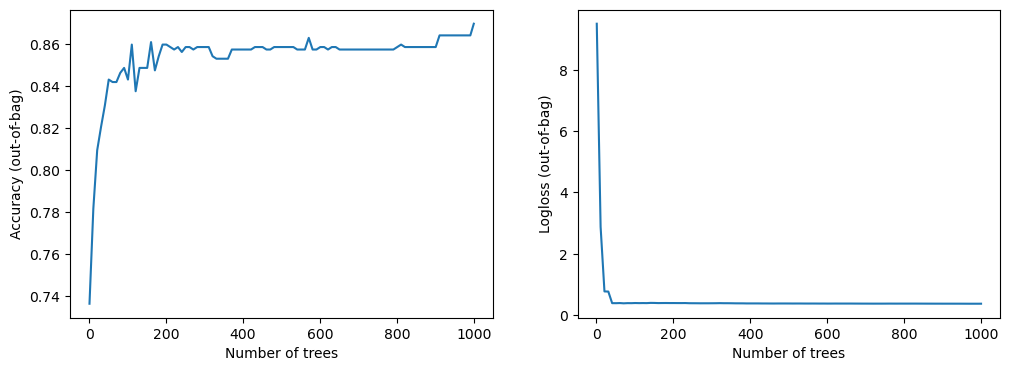


Train: 0.4829 Validation: 0.3269
##### Fold 4
Use /tmp/tmp5w5vd6i_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.219272. Found 514 examples.
Training model...
Model trained in 0:00:00.713726
Compiling model...


[INFO 23-07-29 11:40:25.7456 UTC kernel.cc:1242] Loading model from path /tmp/tmp5w5vd6i_/model/ with prefix 153976b4bdfb4745
[INFO 23-07-29 11:40:25.8768 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33208 node(s), and 113 input feature(s).
[INFO 23-07-29 11:40:25.8769 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:40:25.8769 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 1s 504ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9223 - balanced_log_loss: 0.3500


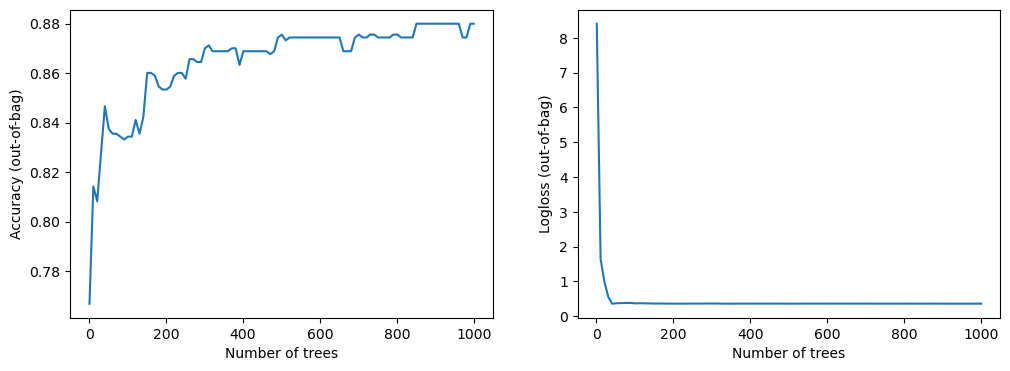


Train: 0.5023 Validation: 0.3500
##### Fold 5
Use /tmp/tmpakmjeg0h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.264435. Found 514 examples.
Training model...
Model trained in 0:00:00.833521
Compiling model...


[INFO 23-07-29 11:40:33.3213 UTC kernel.cc:1242] Loading model from path /tmp/tmpakmjeg0h/model/ with prefix 9551daad7a9d48a6
[INFO 23-07-29 11:40:33.4604 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33428 node(s), and 113 input feature(s).
[INFO 23-07-29 11:40:33.4607 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 398ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9320 - balanced_log_loss: 0.3811


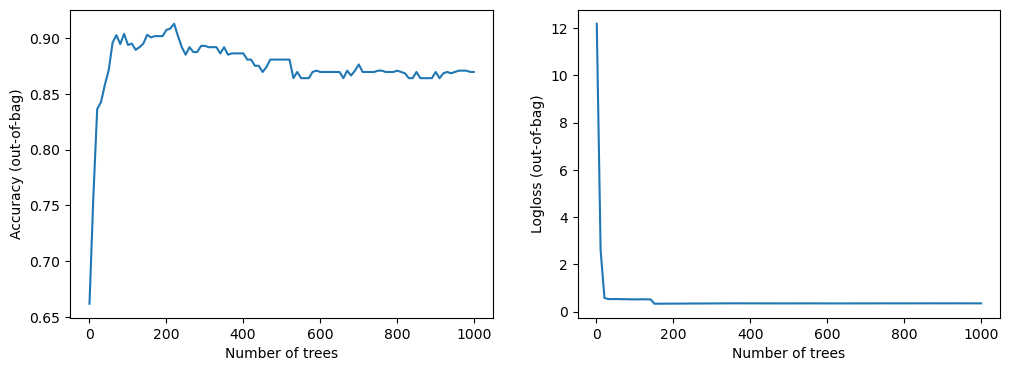


Train: 0.5224 Validation: 0.3811
##### Fold 6
Use /tmp/tmpq09a9ygf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.332147. Found 515 examples.
Training model...
Model trained in 0:00:00.726399
Compiling model...


[INFO 23-07-29 11:40:40.3463 UTC kernel.cc:1242] Loading model from path /tmp/tmpq09a9ygf/model/ with prefix 0a0882f24d77431c
[INFO 23-07-29 11:40:40.4812 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 33260 node(s), and 114 input feature(s).
[INFO 23-07-29 11:40:40.4812 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:40:40.4813 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 402ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9020 - balanced_log_loss: 0.4208


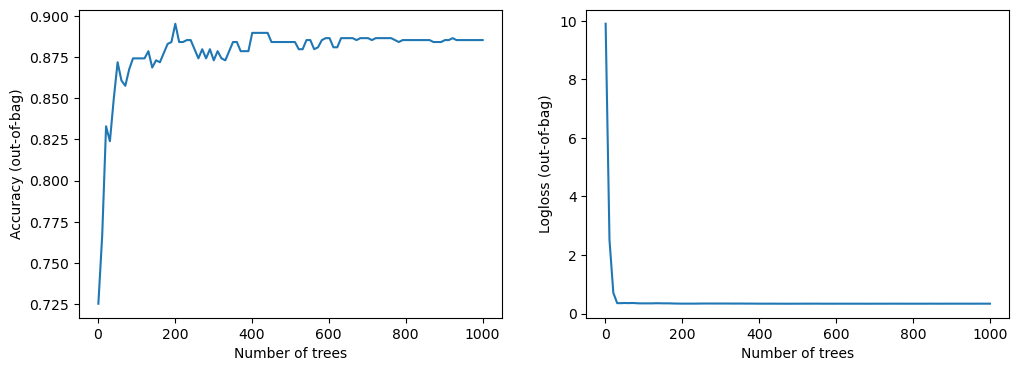


Train: 0.5493 Validation: 0.4208

Train mean: 0.4561 std: 0.1404

Validation mean: 0.3510 std: 0.0437
1/1 [==============================] - 0s 258ms/step


In [10]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_1 = CV_Ensemble_1.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_1.save(save_path='/kaggle/working/RF/1')

# train_summary_rf_3, valid_summary_rf_3, test_summary_rf_3, model_rf_3,metrics_rf_3 

train_summary_rf_1 = CV_Ensemble_1.X_summary
valid_summary_rf_1 = CV_Ensemble_1.valid_summary
test_summary_rf_1 = CV_Ensemble_1.predict(X=test_out)
model_rf_1 = CV_Ensemble_1.models
metrics_rf_1 = CV_Ensemble_1.metrics

##### Fold 1
Use /tmp/tmpc2hcc365 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.383754. Found 555 examples.
Training model...
Model trained in 0:00:00.253533
Compiling model...


[INFO 23-07-29 11:41:24.8572 UTC kernel.cc:1242] Loading model from path /tmp/tmpc2hcc365/model/ with prefix c17f9df09d32455c
[INFO 23-07-29 11:41:24.9009 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10268 node(s), and 112 input feature(s).
[INFO 23-07-29 11:41:24.9009 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:41:24.9010 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 388ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3026


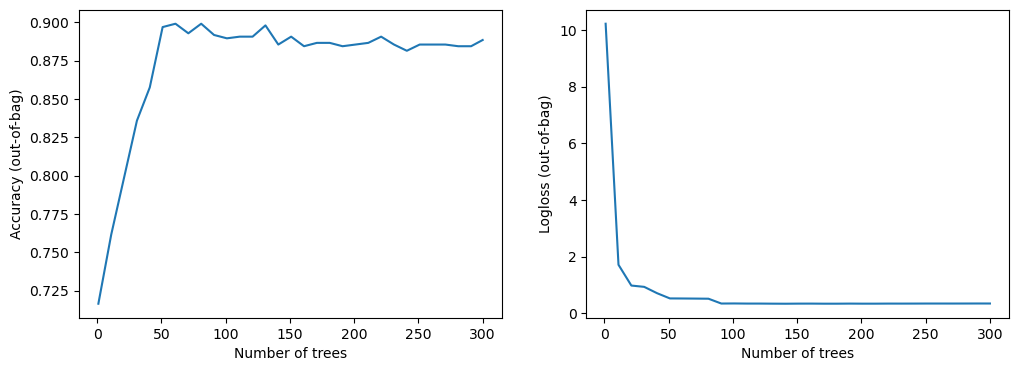


Train: 0.1776 Validation: 0.3026
##### Fold 2
Use /tmp/tmp3in5xs44 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.337330. Found 555 examples.
Training model...
Model trained in 0:00:00.357458
Compiling model...


[INFO 23-07-29 11:41:31.4446 UTC kernel.cc:1242] Loading model from path /tmp/tmp3in5xs44/model/ with prefix 885cb483b6ae4d20
[INFO 23-07-29 11:41:31.4888 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10250 node(s), and 110 input feature(s).
[INFO 23-07-29 11:41:31.4891 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 405ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3518


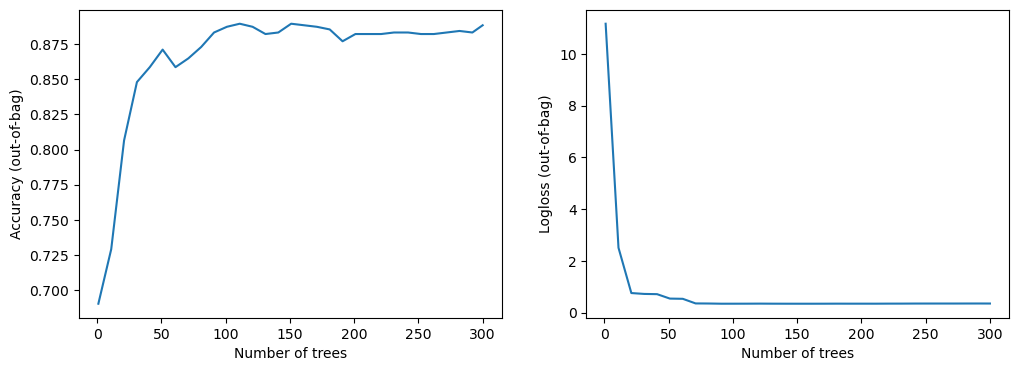


Train: 0.4775 Validation: 0.3518
##### Fold 3
Use /tmp/tmp8m770k_w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.208918. Found 555 examples.
Training model...
Model trained in 0:00:00.251808
Compiling model...


[INFO 23-07-29 11:41:37.7948 UTC kernel.cc:1242] Loading model from path /tmp/tmp8m770k_w/model/ with prefix d576b0294bc2429b
[INFO 23-07-29 11:41:37.8378 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10302 node(s), and 113 input feature(s).
[INFO 23-07-29 11:41:37.8378 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:41:37.8379 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 396ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2532


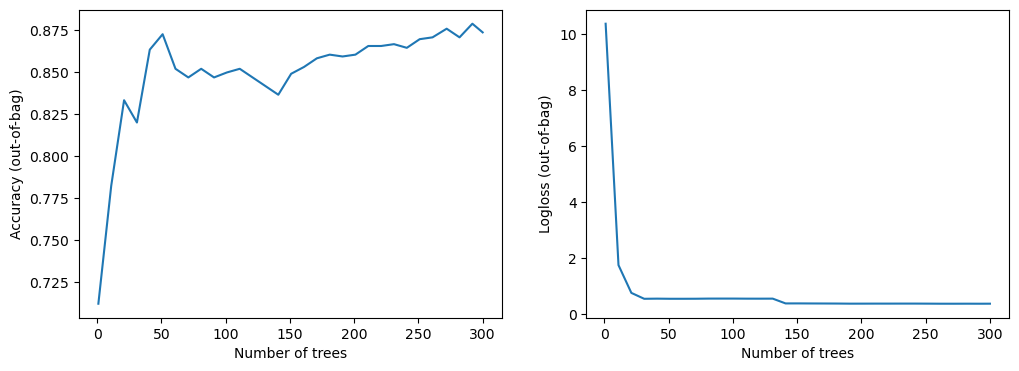


Train: 0.5394 Validation: 0.2532
##### Fold 4
Use /tmp/tmp89_b_7ac as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.204771. Found 555 examples.
Training model...
Model trained in 0:00:00.246691
Compiling model...


[INFO 23-07-29 11:41:44.0246 UTC kernel.cc:1242] Loading model from path /tmp/tmp89_b_7ac/model/ with prefix ad945a3b0e3e424f
[INFO 23-07-29 11:41:44.0687 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10350 node(s), and 112 input feature(s).
[INFO 23-07-29 11:41:44.0688 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 403ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.3232


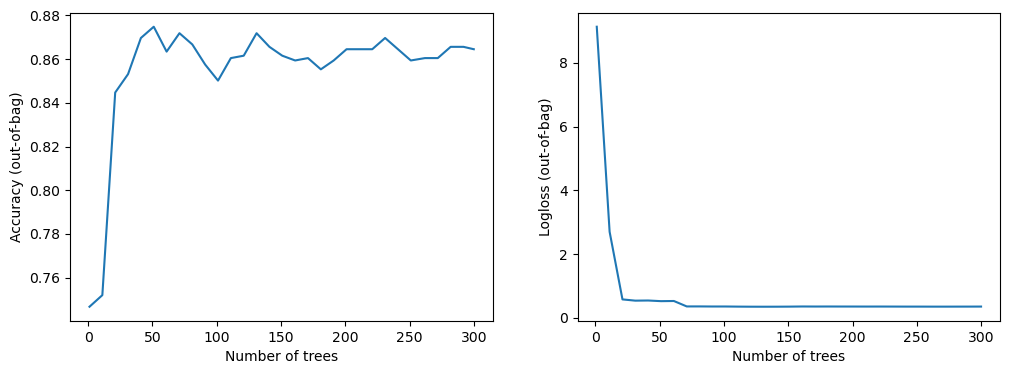


Train: 0.4308 Validation: 0.3232
##### Fold 5
Use /tmp/tmp9c08ej7o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.184719. Found 555 examples.
Training model...
Model trained in 0:00:00.244901
Compiling model...


[INFO 23-07-29 11:41:51.2951 UTC kernel.cc:1242] Loading model from path /tmp/tmp9c08ej7o/model/ with prefix 59618b77b3ba4ff0
[INFO 23-07-29 11:41:51.3382 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10290 node(s), and 112 input feature(s).
[INFO 23-07-29 11:41:51.3383 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:41:51.3383 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 394ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3334


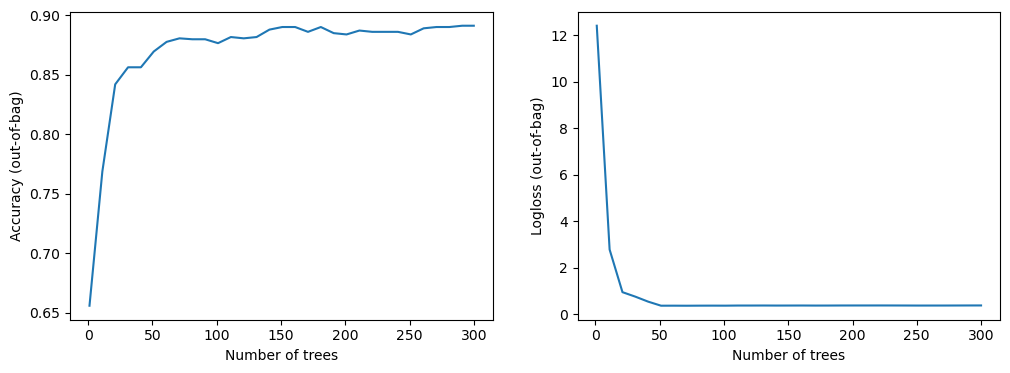


Train: 0.5062 Validation: 0.3334
##### Fold 6
Use /tmp/tmpttqrhtn0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.466251. Found 555 examples.
Training model...
Model trained in 0:00:00.256233
Compiling model...


[INFO 23-07-29 11:41:59.4318 UTC kernel.cc:1242] Loading model from path /tmp/tmpttqrhtn0/model/ with prefix 38cfa9845de442ae
[INFO 23-07-29 11:41:59.4772 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10464 node(s), and 113 input feature(s).
[INFO 23-07-29 11:41:59.4773 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 408ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.4007


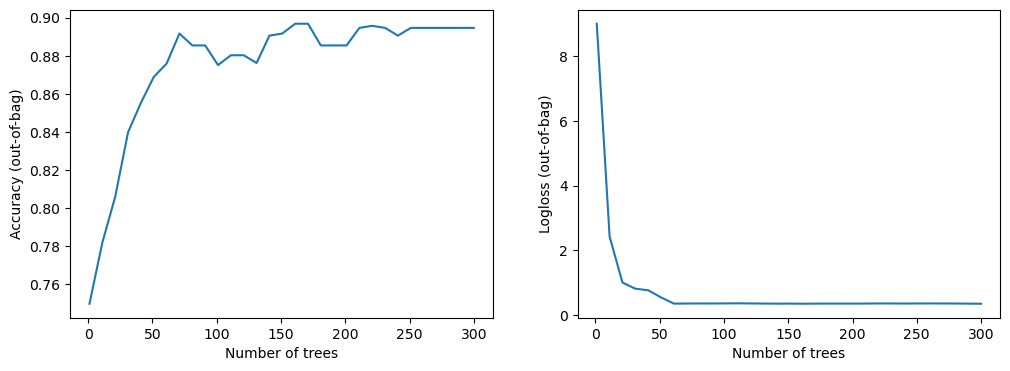


Train: 0.5031 Validation: 0.4007
##### Fold 7
Use /tmp/tmpavv703dp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.142863. Found 555 examples.
Training model...
Model trained in 0:00:00.241307
Compiling model...


[INFO 23-07-29 11:42:06.7692 UTC kernel.cc:1242] Loading model from path /tmp/tmpavv703dp/model/ with prefix 9cc9cb88ea9e470b
[INFO 23-07-29 11:42:06.8099 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10096 node(s), and 113 input feature(s).
[INFO 23-07-29 11:42:06.8100 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:42:06.8100 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 381ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3264


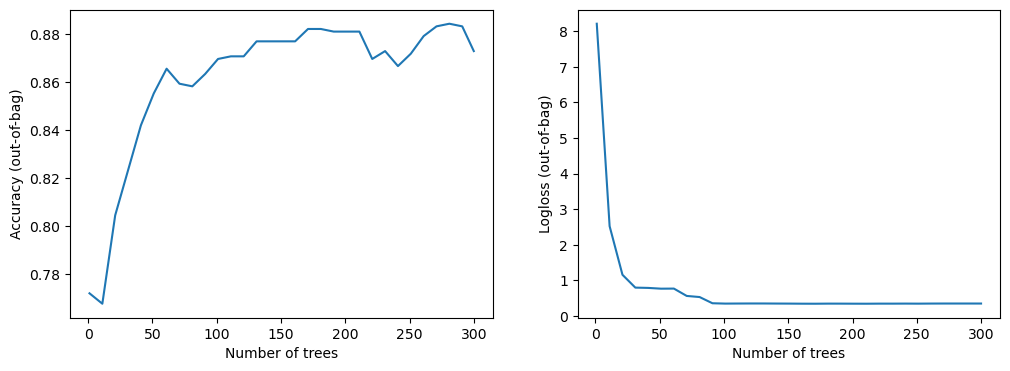


Train: 0.5776 Validation: 0.3264
##### Fold 8
Use /tmp/tmpeu0jvohd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.157809. Found 556 examples.
Training model...
Model trained in 0:00:00.242546
Compiling model...


[INFO 23-07-29 11:42:13.9133 UTC kernel.cc:1242] Loading model from path /tmp/tmpeu0jvohd/model/ with prefix 8cfbc5e891bd418e
[INFO 23-07-29 11:42:13.9550 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10276 node(s), and 113 input feature(s).
[INFO 23-07-29 11:42:13.9550 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.3201


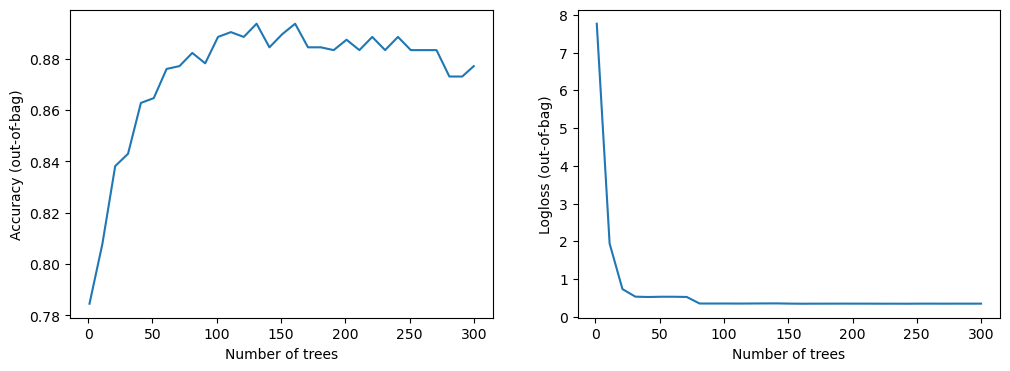


Train: 0.5045 Validation: 0.3201
##### Fold 9
Use /tmp/tmpzlcaxn1i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.198710. Found 556 examples.
Training model...
Model trained in 0:00:00.246276
Compiling model...


[INFO 23-07-29 11:42:20.0811 UTC kernel.cc:1242] Loading model from path /tmp/tmpzlcaxn1i/model/ with prefix 8f8a0135250f41bd
[INFO 23-07-29 11:42:20.1292 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10168 node(s), and 112 input feature(s).
[INFO 23-07-29 11:42:20.1292 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:42:20.1293 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 366ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4664


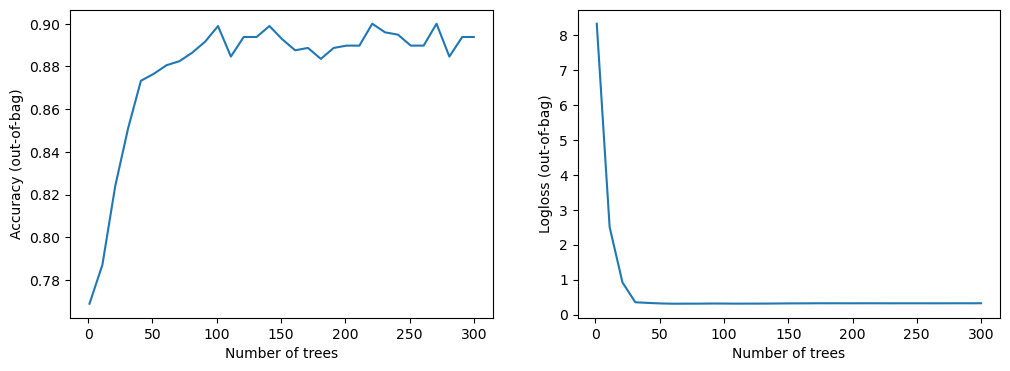


Train: 0.4883 Validation: 0.4664
##### Fold 10
Use /tmp/tmpmnybsiqq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.272717. Found 556 examples.
Training model...
Model trained in 0:00:00.257539
Compiling model...


[INFO 23-07-29 11:42:26.2925 UTC kernel.cc:1242] Loading model from path /tmp/tmpmnybsiqq/model/ with prefix 14c00dd5b7f54d0b
[INFO 23-07-29 11:42:26.3376 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10406 node(s), and 111 input feature(s).
[INFO 23-07-29 11:42:26.3377 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 384ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.3531


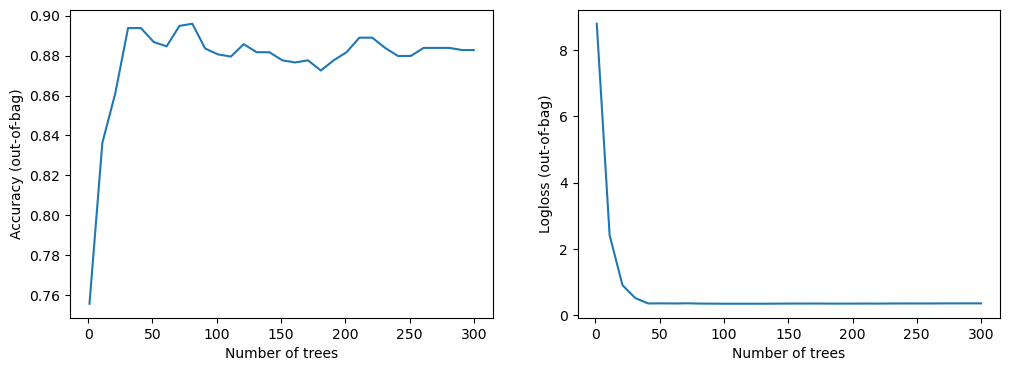


Train: 0.6396 Validation: 0.3531

Train mean: 0.4845 std: 0.1221

Validation mean: 0.3431 std: 0.0574
1/1 [==============================] - 0s 227ms/step


In [11]:
# RandomForestModel

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_2 = CV_Ensemble_2.fit(X=train_out, features=features, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_2.save(save_path='/kaggle/working/RF/2')

# Collect attributes and predictions

train_summary_rf_2 = CV_Ensemble_2.X_summary
valid_summary_rf_2 = CV_Ensemble_2.valid_summary
test_summary_rf_2 = CV_Ensemble_2.predict(X=test_out)
model_rf_2 = CV_Ensemble_2.models
metrics_rf_2 = CV_Ensemble_2.metrics


##### Fold 1
Use /tmp/tmp3ryaztph as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.228859. Found 555 examples.
Training model...
Model trained in 0:00:00.191186
Compiling model...


[INFO 23-07-29 11:43:33.2034 UTC kernel.cc:1242] Loading model from path /tmp/tmp3ryaztph/model/ with prefix 7d63cbae5c184639
[INFO 23-07-29 11:43:33.2484 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11260 node(s), and 59 input feature(s).
[INFO 23-07-29 11:43:33.2484 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:43:33.2485 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_log_loss: 0.3091


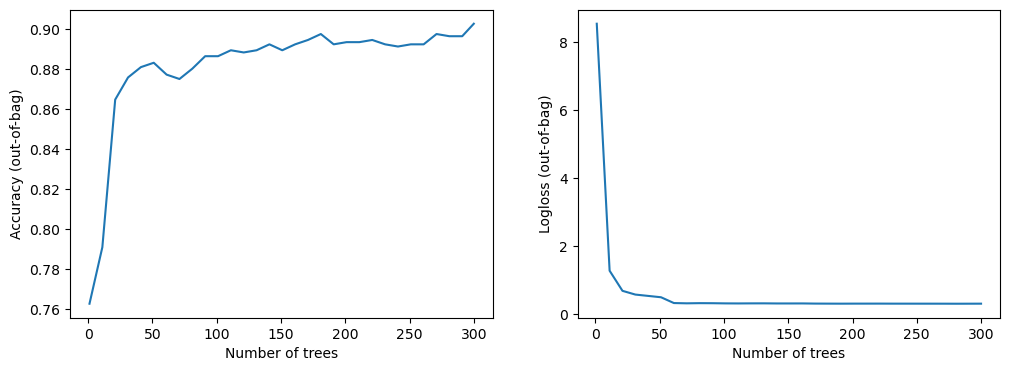


Train: 0.1883 Validation: 0.3091
##### Fold 2
Use /tmp/tmp2lmovape as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.222711. Found 555 examples.
Training model...
Model trained in 0:00:00.185806
Compiling model...


[INFO 23-07-29 11:43:37.0658 UTC kernel.cc:1242] Loading model from path /tmp/tmp2lmovape/model/ with prefix 0f353a8c9fb14106
[INFO 23-07-29 11:43:37.1129 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-29 11:43:37.1129 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3418


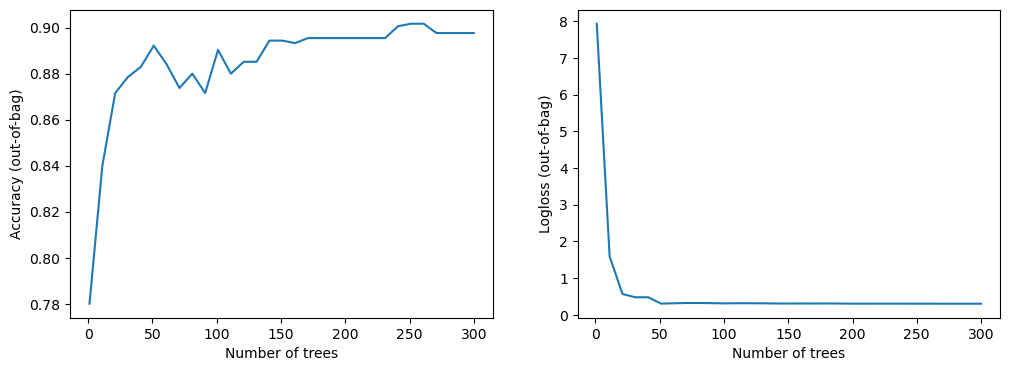


Train: 0.4968 Validation: 0.3418
##### Fold 3
Use /tmp/tmpsot6nbfk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.211801. Found 555 examples.
Training model...
Model trained in 0:00:00.191017
Compiling model...


[INFO 23-07-29 11:43:41.0037 UTC kernel.cc:1242] Loading model from path /tmp/tmpsot6nbfk/model/ with prefix 0c80d038d9724314
[INFO 23-07-29 11:43:41.0504 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-29 11:43:41.0504 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 276ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_log_loss: 0.2186


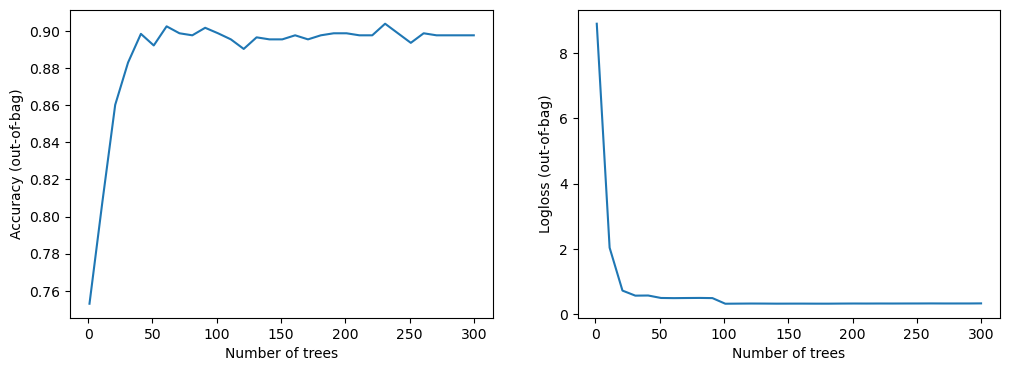


Train: 0.5382 Validation: 0.2186
##### Fold 4
Use /tmp/tmpet0c1xla as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.227765. Found 555 examples.
Training model...
Model trained in 0:00:00.186528
Compiling model...


[INFO 23-07-29 11:43:45.2484 UTC kernel.cc:1242] Loading model from path /tmp/tmpet0c1xla/model/ with prefix 57672f53130342d7
[INFO 23-07-29 11:43:45.2929 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11274 node(s), and 58 input feature(s).
[INFO 23-07-29 11:43:45.2930 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:43:45.2930 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 263ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2880


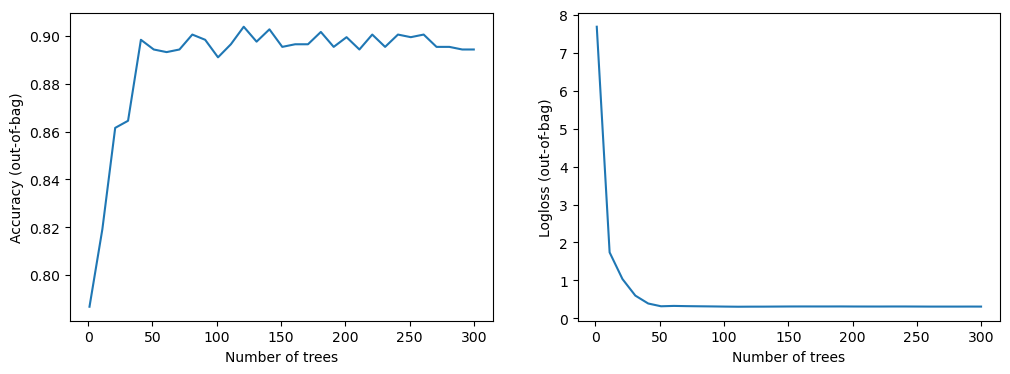


Train: 0.4091 Validation: 0.2880
##### Fold 5
Use /tmp/tmpj4hvv0f0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.214433. Found 555 examples.
Training model...
Model trained in 0:00:00.190006
Compiling model...


[INFO 23-07-29 11:43:49.0459 UTC kernel.cc:1242] Loading model from path /tmp/tmpj4hvv0f0/model/ with prefix cf1bb21052324fd5
[INFO 23-07-29 11:43:49.0907 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11210 node(s), and 58 input feature(s).
[INFO 23-07-29 11:43:49.0907 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2901


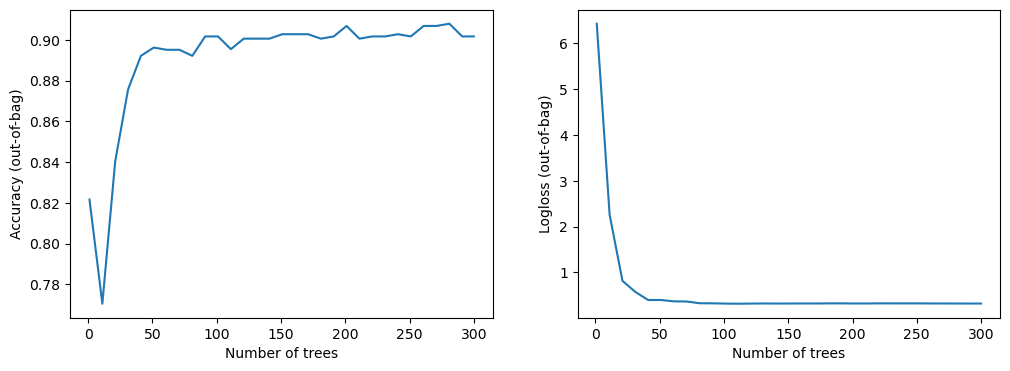


Train: 0.4847 Validation: 0.2901
##### Fold 6
Use /tmp/tmpld3znrmz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.234003. Found 555 examples.
Training model...
Model trained in 0:00:00.189282
Compiling model...


[INFO 23-07-29 11:43:52.8200 UTC kernel.cc:1242] Loading model from path /tmp/tmpld3znrmz/model/ with prefix 89b5bece9909453b
[INFO 23-07-29 11:43:52.8650 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11268 node(s), and 58 input feature(s).
[INFO 23-07-29 11:43:52.8650 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3444


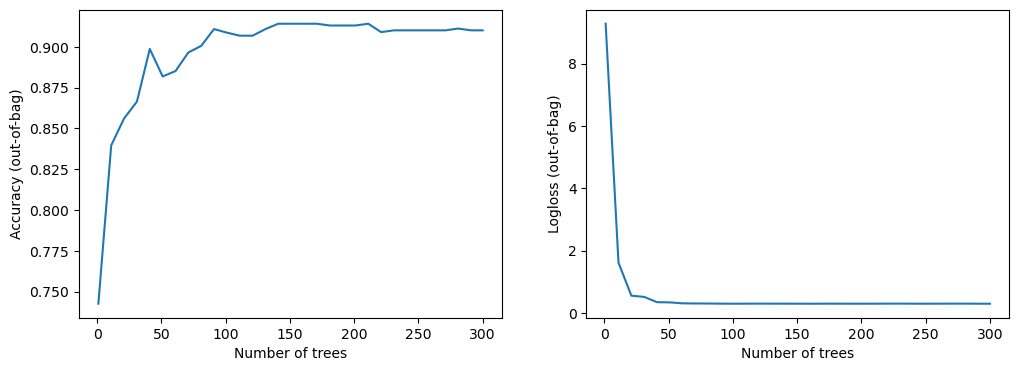


Train: 0.4697 Validation: 0.3444
##### Fold 7
Use /tmp/tmp1yfn_jlf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.233492. Found 555 examples.
Training model...
Model trained in 0:00:00.187492
Compiling model...


[INFO 23-07-29 11:43:56.9918 UTC kernel.cc:1242] Loading model from path /tmp/tmp1yfn_jlf/model/ with prefix 35f8cee7385f46ed
[INFO 23-07-29 11:43:57.0360 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11172 node(s), and 58 input feature(s).
[INFO 23-07-29 11:43:57.0360 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:43:57.0361 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 266ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2836


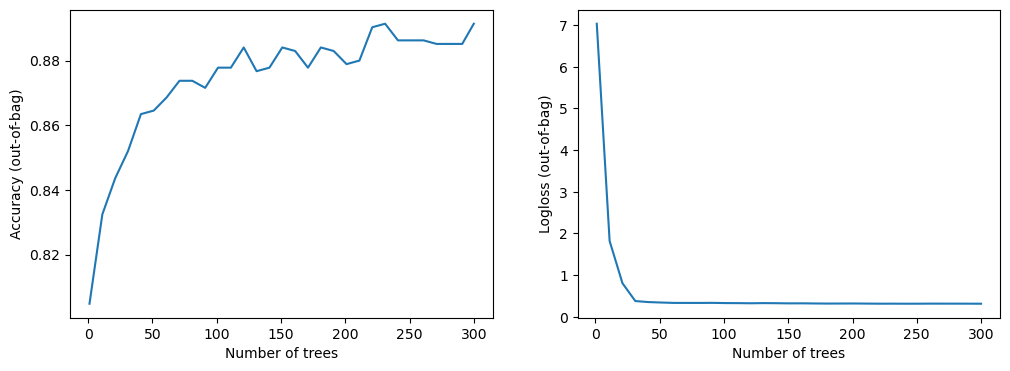


Train: 0.5343 Validation: 0.2836
##### Fold 8
Use /tmp/tmpo9ra20dr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.194467. Found 556 examples.
Training model...
Model trained in 0:00:00.187738
Compiling model...


[INFO 23-07-29 11:44:00.7350 UTC kernel.cc:1242] Loading model from path /tmp/tmpo9ra20dr/model/ with prefix 17db4a1edc204313
[INFO 23-07-29 11:44:00.7788 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11026 node(s), and 58 input feature(s).
[INFO 23-07-29 11:44:00.7789 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 275ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.2572


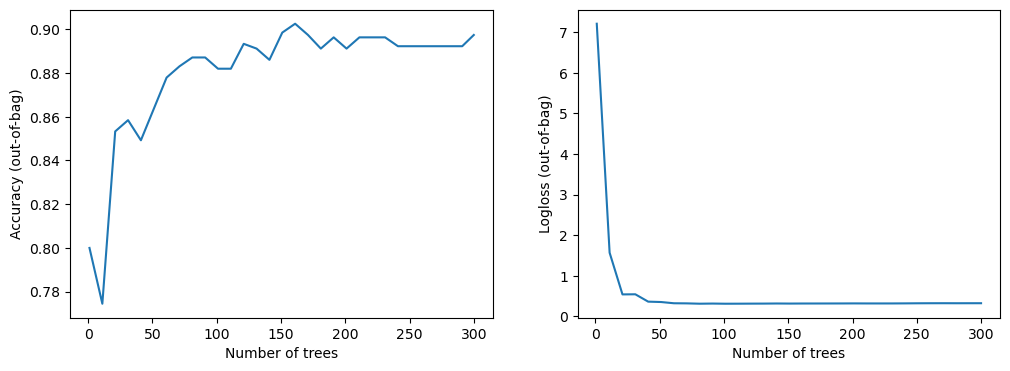


Train: 0.4778 Validation: 0.2572
##### Fold 9
Use /tmp/tmpoyriu_ru as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.320573. Found 556 examples.
Training model...
Model trained in 0:00:00.187694
Compiling model...


[INFO 23-07-29 11:44:04.7287 UTC kernel.cc:1242] Loading model from path /tmp/tmpoyriu_ru/model/ with prefix e06d81439f044488
[INFO 23-07-29 11:44:04.7726 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11098 node(s), and 58 input feature(s).
[INFO 23-07-29 11:44:04.7727 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 300ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_log_loss: 0.4250


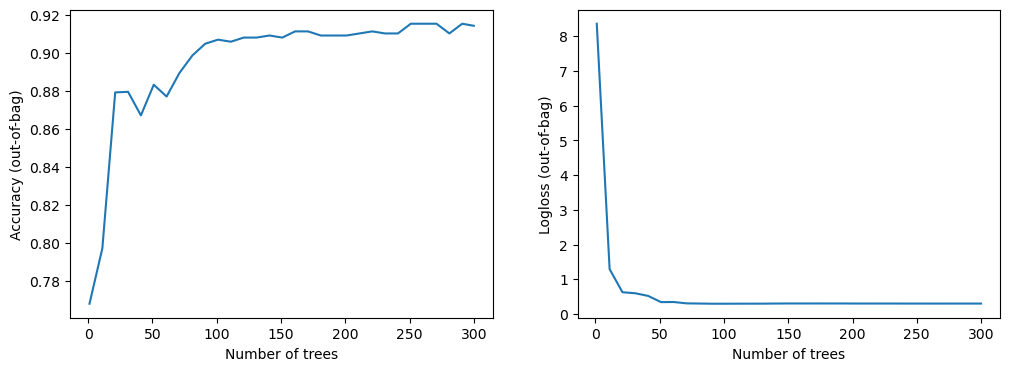


Train: 0.4395 Validation: 0.4250
##### Fold 10
Use /tmp/tmps1qqui3h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.310315. Found 556 examples.
Training model...
Model trained in 0:00:00.220034
Compiling model...


[INFO 23-07-29 11:44:09.7495 UTC kernel.cc:1242] Loading model from path /tmp/tmps1qqui3h/model/ with prefix 26a321e5bb624ca4
[INFO 23-07-29 11:44:09.7964 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11344 node(s), and 58 input feature(s).
[INFO 23-07-29 11:44:09.7964 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-29 11:44:09.7965 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3016


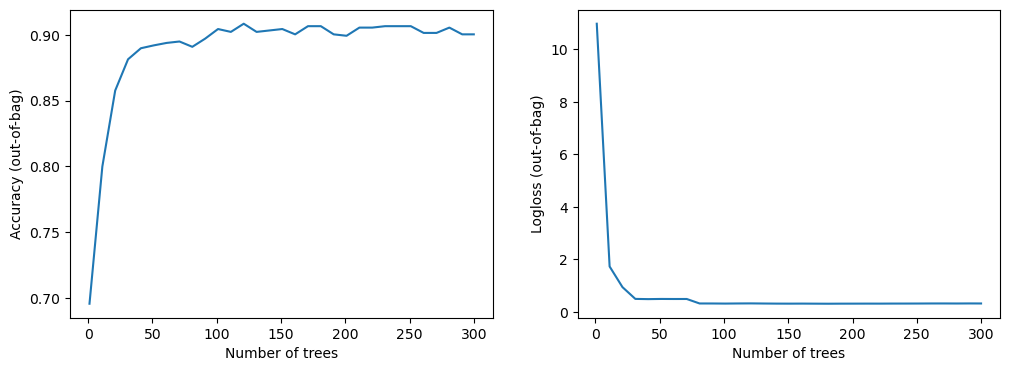


Train: 0.6154 Validation: 0.3016

Train mean: 0.4654 std: 0.1129

Validation mean: 0.3059 std: 0.0558
1/1 [==============================] - 0s 144ms/step


In [12]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_3 = TFDF_CV_Ensemble(model_obj=tfdf.keras.RandomForestModel, label="Class")

# train
CV_Ensemble_3 = CV_Ensemble_3.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=6, num_trees=300),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_3.save(save_path='/kaggle/working/RF/3')

# Collect attributes and predictions

train_summary_rf_3 = CV_Ensemble_3.X_summary
valid_summary_rf_3 = CV_Ensemble_3.valid_summary
test_summary_rf_3 = CV_Ensemble_3.predict(X=test_out)
model_rf_3 = CV_Ensemble_3.models
metrics_rf_3 = CV_Ensemble_3.metrics

# GradientBoostedTreesModel

##### Fold 1
Use /tmp/tmpposvm98b as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:44:46.4496 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:44:46.4497 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:44:46.4497 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.219473. Found 555 examples.
Training model...
Model trained in 0:00:00.749090
Compiling model...


[INFO 23-07-29 11:44:48.4222 UTC kernel.cc:1242] Loading model from path /tmp/tmpposvm98b/model/ with prefix 1aea9135ffec4697
[INFO 23-07-29 11:44:48.4276 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 11:44:48.4277 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 277ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2432


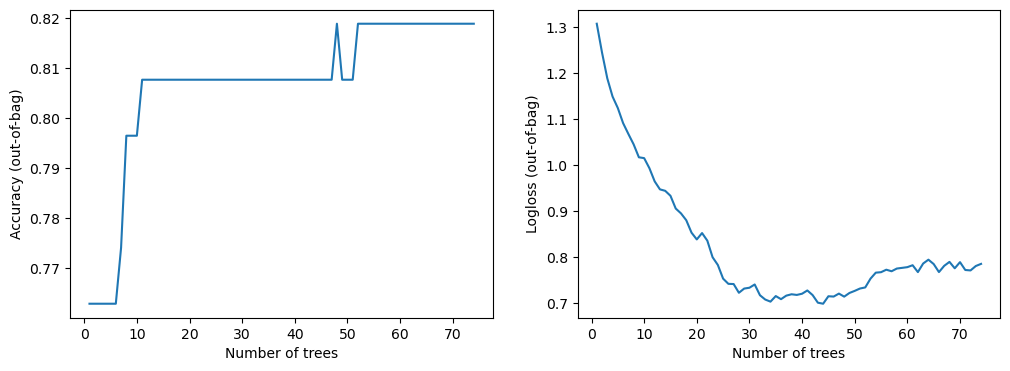


Train: 0.0893 Validation: 0.2432
##### Fold 2
Use /tmp/tmpy_e367v7 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:44:50.8843 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:44:50.8843 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:44:50.8843 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.257073. Found 555 examples.
Training model...
Model trained in 0:00:00.723613
Compiling model...


[INFO 23-07-29 11:44:52.8696 UTC kernel.cc:1242] Loading model from path /tmp/tmpy_e367v7/model/ with prefix ea9bc39049374bc1
[INFO 23-07-29 11:44:52.8746 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 313ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2464


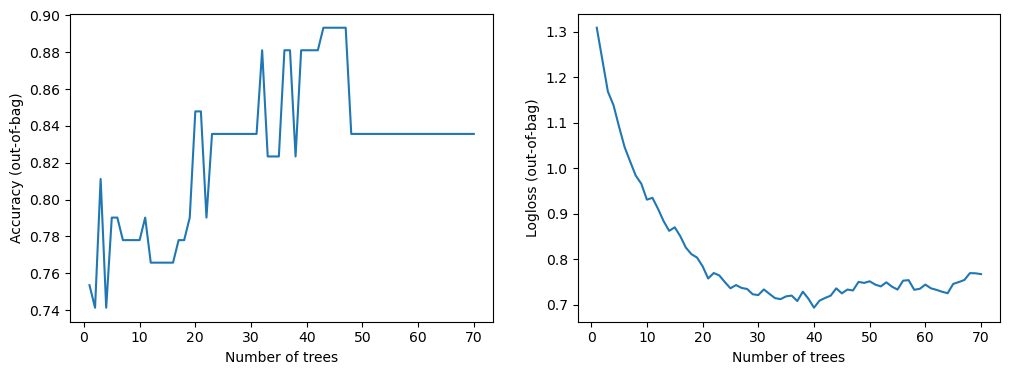


Train: 0.3326 Validation: 0.2464
##### Fold 3
Use /tmp/tmpx6o5owj5 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:44:59.1649 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:44:59.1649 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:44:59.1649 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.312461. Found 555 examples.
Training model...
Model trained in 0:00:00.896916
Compiling model...


[INFO 23-07-29 11:45:01.3762 UTC kernel.cc:1242] Loading model from path /tmp/tmpx6o5owj5/model/ with prefix 36e03f8abdcb4de1
[INFO 23-07-29 11:45:01.3839 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 11:45:01.3840 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1154


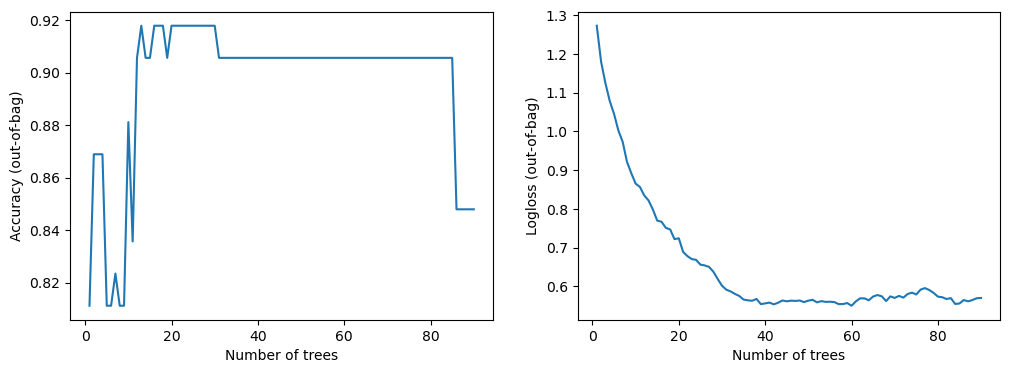


Train: 0.3043 Validation: 0.1154
##### Fold 4
Use /tmp/tmp_bpa_2v9 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:45:03.8507 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:03.8507 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:03.8507 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.265254. Found 555 examples.
Training model...
Model trained in 0:00:00.633420
Compiling model...


[INFO 23-07-29 11:45:05.7544 UTC kernel.cc:1242] Loading model from path /tmp/tmp_bpa_2v9/model/ with prefix 1764093b49f049a0
[INFO 23-07-29 11:45:05.7590 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2950


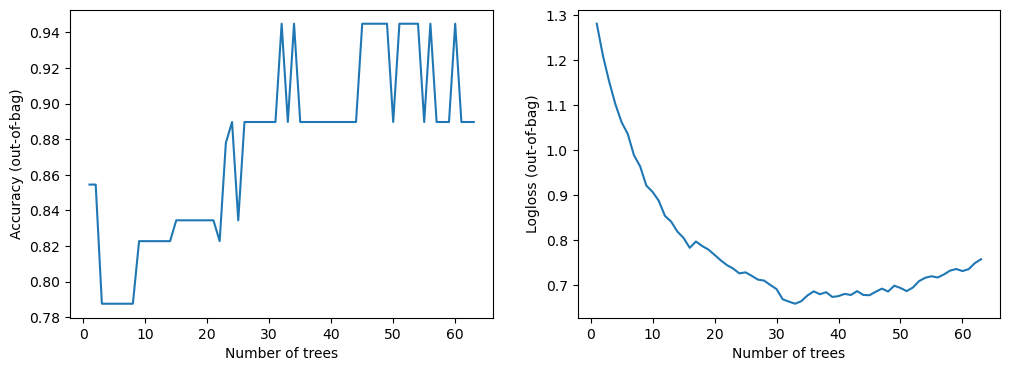


Train: 0.2279 Validation: 0.2950
##### Fold 5
Use /tmp/tmpewyqgu4s as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:45:08.1706 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:08.1708 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:08.1709 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.218582. Found 555 examples.
Training model...
Model trained in 0:00:00.982597
Compiling model...


[INFO 23-07-29 11:45:10.3721 UTC kernel.cc:1242] Loading model from path /tmp/tmpewyqgu4s/model/ with prefix 97ad59dd6f874e83
[INFO 23-07-29 11:45:10.3806 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 294ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_log_loss: 0.2456


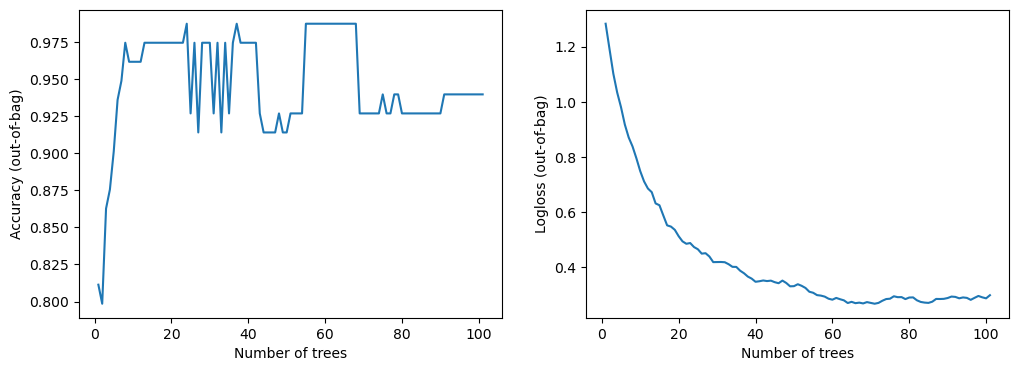


Train: 0.3301 Validation: 0.2456
##### Fold 6
Use /tmp/tmp5zs0zjhc as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:45:12.7979 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:12.7980 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:12.7980 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.223819. Found 555 examples.
Training model...
Model trained in 0:00:00.919817
Compiling model...


[INFO 23-07-29 11:45:14.9449 UTC kernel.cc:1242] Loading model from path /tmp/tmp5zs0zjhc/model/ with prefix 281e5227100b442f
[INFO 23-07-29 11:45:14.9522 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 11:45:14.9523 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 270ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3147


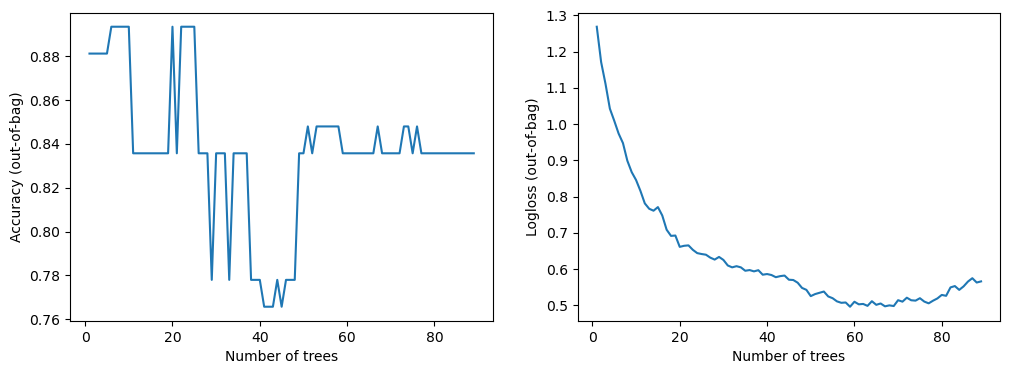


Train: 0.2965 Validation: 0.3147
##### Fold 7
Use /tmp/tmpu3ymgw96 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:45:17.2587 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:17.2590 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:17.2591 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.275303. Found 555 examples.
Training model...
Model trained in 0:00:01.050627
Compiling model...


[INFO 23-07-29 11:45:19.5844 UTC kernel.cc:1242] Loading model from path /tmp/tmpu3ymgw96/model/ with prefix 71200c2cd94c4b67
[INFO 23-07-29 11:45:19.5934 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 263ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.3183


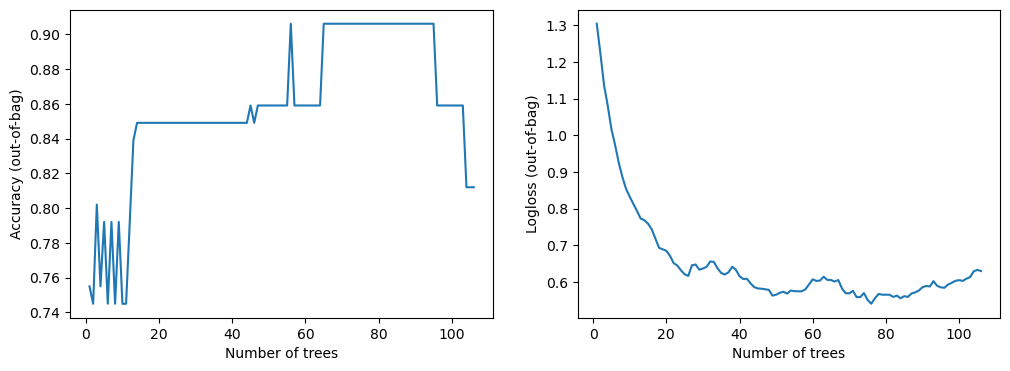


Train: 0.3593 Validation: 0.3183
##### Fold 8
Use /tmp/tmpia33m8b9 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:45:21.9380 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:21.9381 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:21.9381 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.256257. Found 556 examples.
Training model...
Model trained in 0:00:01.160514
Compiling model...


[INFO 23-07-29 11:45:24.3544 UTC kernel.cc:1242] Loading model from path /tmp/tmpia33m8b9/model/ with prefix 39aea6dc66c04125
[INFO 23-07-29 11:45:24.3639 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 263ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_log_loss: 0.1722


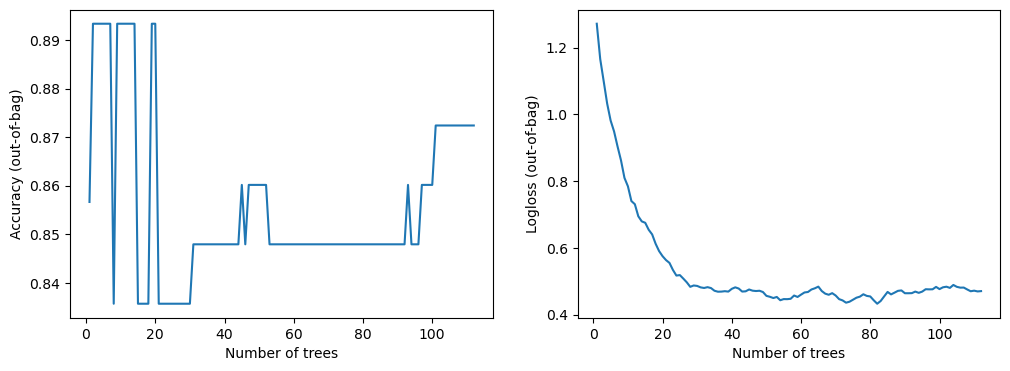


Train: 0.3549 Validation: 0.1722
##### Fold 9
Use /tmp/tmpc3512lyz as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:45:26.6691 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:26.6692 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:26.6692 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.242351. Found 556 examples.
Training model...
Model trained in 0:00:02.030259
Compiling model...


[INFO 23-07-29 11:45:29.9307 UTC kernel.cc:1242] Loading model from path /tmp/tmpc3512lyz/model/ with prefix 5e69358b621c47f9
[INFO 23-07-29 11:45:29.9504 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 11:45:29.9504 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.9113


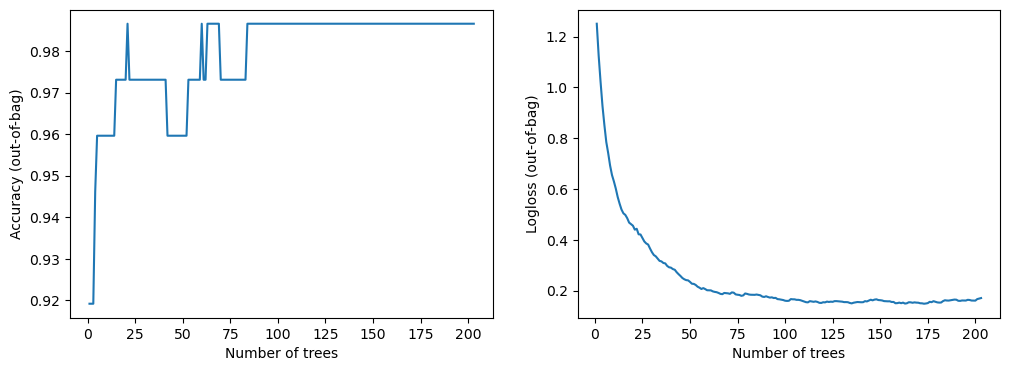


Train: 0.1788 Validation: 0.9113
##### Fold 10
Use /tmp/tmpwiz05ne5 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:45:32.3655 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:32.3657 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:45:32.3658 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.250474. Found 556 examples.
Training model...
Model trained in 0:00:01.313510
Compiling model...


[INFO 23-07-29 11:45:34.9266 UTC kernel.cc:1242] Loading model from path /tmp/tmpwiz05ne5/model/ with prefix 75ca29f7f9824f9f
[INFO 23-07-29 11:45:34.9389 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.1701


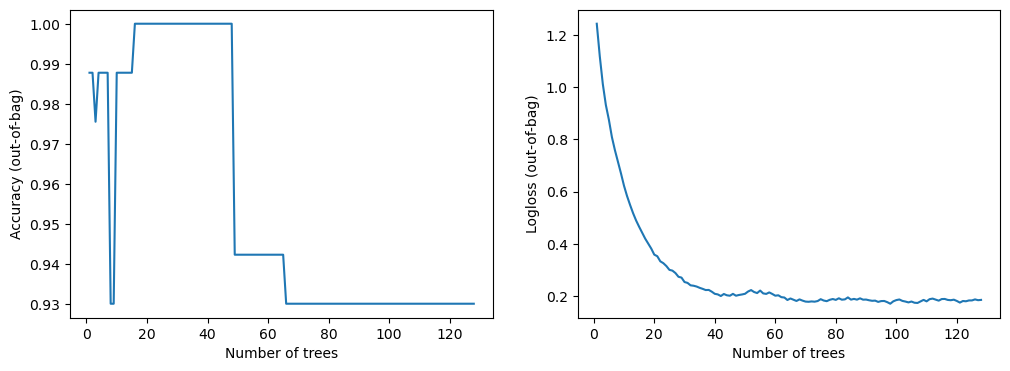


Train: 0.9280 Validation: 0.1701

Train mean: 0.3402 std: 0.2239

Validation mean: 0.3032 std: 0.2237
1/1 [==============================] - 0s 138ms/step


In [13]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_1 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_1 = CV_Ensemble_GBT_1.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=5, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_GBT_1.save(save_path='/kaggle/working/GBT/1')

# Collect attributes and predictions

train_summary_gbt_1 = CV_Ensemble_GBT_1.X_summary
valid_summary_gbt_1 = CV_Ensemble_GBT_1.valid_summary
test_summary_gbt_1 = CV_Ensemble_GBT_1.predict(X=test_out)
model_gbt_1 = CV_Ensemble_GBT_1.models
metrics_gbt_1 = CV_Ensemble_GBT_1.metrics

##### Fold 1
Use /tmp/tmpmxt0r83p as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:12.6694 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:12.6695 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:12.6695 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.235631. Found 555 examples.
Training model...
Model trained in 0:00:01.239851
Compiling model...


[INFO 23-07-29 11:46:15.1429 UTC kernel.cc:1242] Loading model from path /tmp/tmpmxt0r83p/model/ with prefix 55998cd96ad44cc9
[INFO 23-07-29 11:46:15.1540 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 11:46:15.1541 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 266ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.2472


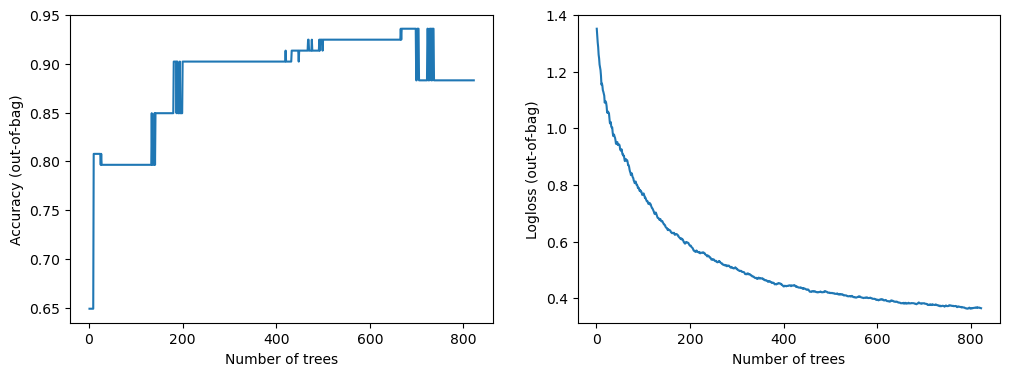


Train: 0.1104 Validation: 0.2472
##### Fold 2
Use /tmp/tmpbnnp7_44 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:18.1443 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:18.1443 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:18.1443 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.239016. Found 555 examples.
Training model...
Model trained in 0:00:00.719473
Compiling model...


[INFO 23-07-29 11:46:20.1035 UTC kernel.cc:1242] Loading model from path /tmp/tmpbnnp7_44/model/ with prefix 172bf38bf2f54489
[INFO 23-07-29 11:46:20.1111 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 268ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_log_loss: 0.3298


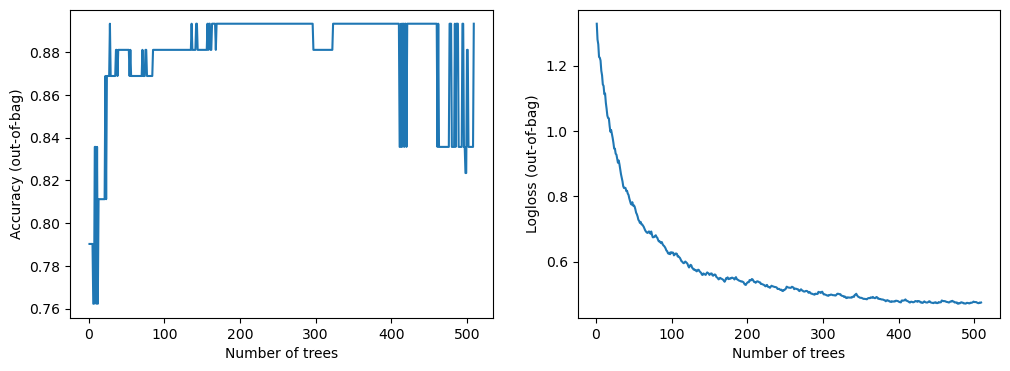


Train: 0.3734 Validation: 0.3298
##### Fold 3
Use /tmp/tmp94ztioc7 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:22.4587 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:22.4587 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:22.4587 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.276755. Found 555 examples.
Training model...
Model trained in 0:00:01.428745
Compiling model...


[INFO 23-07-29 11:46:25.1595 UTC kernel.cc:1242] Loading model from path /tmp/tmp94ztioc7/model/ with prefix 6c729a30c24a4ff0
[INFO 23-07-29 11:46:25.1734 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 11:46:25.1735 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 265ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.1800


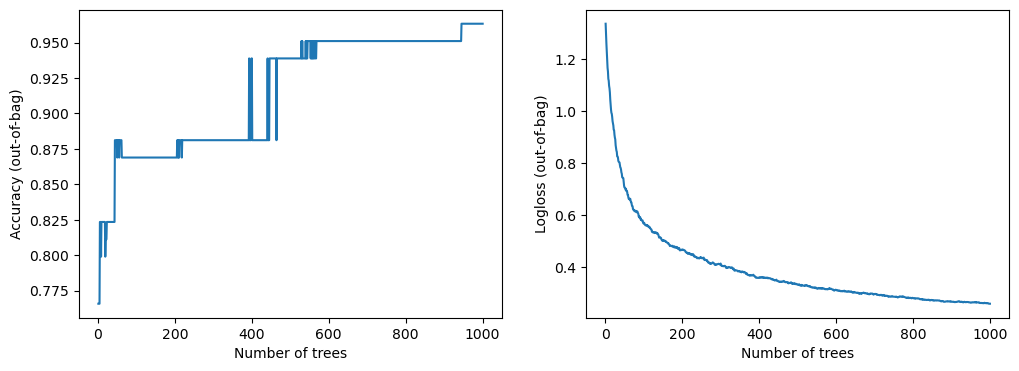


Train: 0.4286 Validation: 0.1800
##### Fold 4
Use /tmp/tmppzeseayz as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:27.9700 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:27.9701 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:27.9701 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.288539. Found 555 examples.
Training model...
Model trained in 0:00:00.410991
Compiling model...


[INFO 23-07-29 11:46:29.6755 UTC kernel.cc:1242] Loading model from path /tmp/tmppzeseayz/model/ with prefix 82de4a3435a148c5
[INFO 23-07-29 11:46:29.6796 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2218


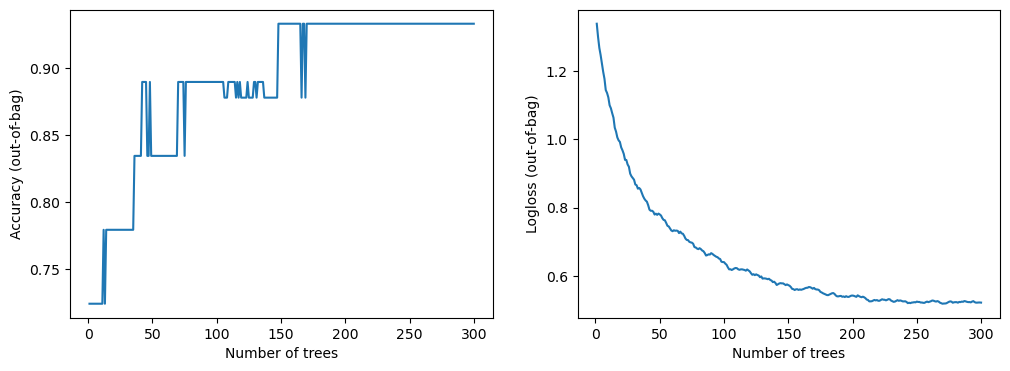


Train: 0.3504 Validation: 0.2218
##### Fold 5
Use /tmp/tmpfxk_n9k3 as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:31.9795 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:31.9795 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:31.9795 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.238510. Found 555 examples.
Training model...
Model trained in 0:00:00.562323
Compiling model...


[INFO 23-07-29 11:46:33.7829 UTC kernel.cc:1242] Loading model from path /tmp/tmpfxk_n9k3/model/ with prefix 270abbae439e4013
[INFO 23-07-29 11:46:33.7885 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 266ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_log_loss: 0.2437


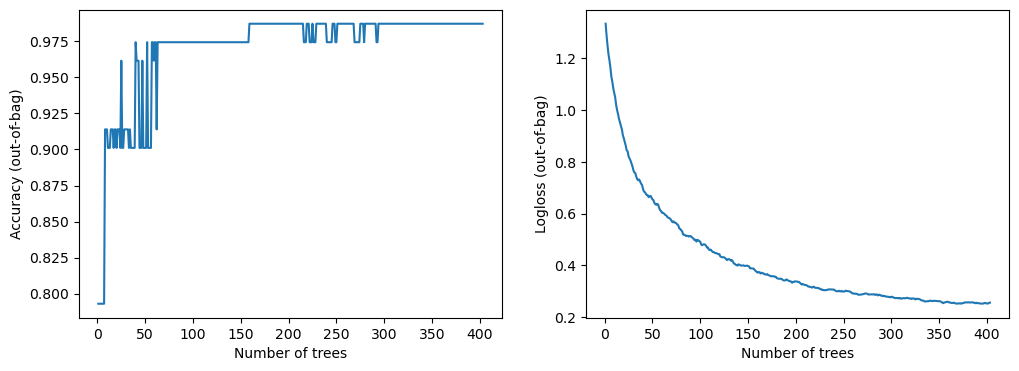


Train: 0.3695 Validation: 0.2437
##### Fold 6
Use /tmp/tmp24pky2nu as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:37.4703 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:37.4703 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:37.4704 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.266124. Found 555 examples.
Training model...
Model trained in 0:00:00.671305
Compiling model...


[INFO 23-07-29 11:46:39.4108 UTC kernel.cc:1242] Loading model from path /tmp/tmp24pky2nu/model/ with prefix ea71844a1c1d480c
[INFO 23-07-29 11:46:39.4174 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 11:46:39.4175 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 262ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_log_loss: 0.2334


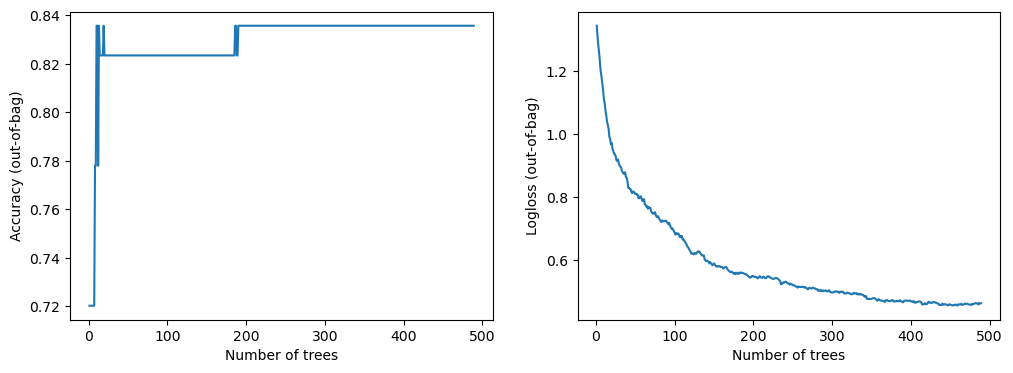


Train: 0.3818 Validation: 0.2334
##### Fold 7
Use /tmp/tmpdp_u9rma as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:42.9327 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:42.9328 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:42.9328 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.258024. Found 555 examples.
Training model...
Model trained in 0:00:00.642250
Compiling model...


[INFO 23-07-29 11:46:44.8367 UTC kernel.cc:1242] Loading model from path /tmp/tmpdp_u9rma/model/ with prefix 5ff1b9aaa93144aa
[INFO 23-07-29 11:46:44.8431 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 283ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_log_loss: 0.1783


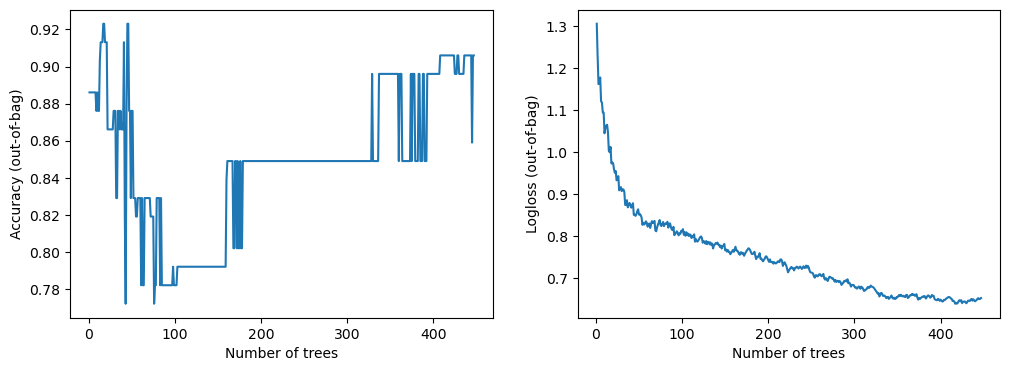


Train: 0.3857 Validation: 0.1783
##### Fold 8
Use /tmp/tmpa7dz1r_w as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:47.2387 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:47.2387 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:47.2387 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.273232. Found 556 examples.
Training model...
Model trained in 0:00:00.695741
Compiling model...


[INFO 23-07-29 11:46:49.2116 UTC kernel.cc:1242] Loading model from path /tmp/tmpa7dz1r_w/model/ with prefix ebaa009f8adc43bf
[INFO 23-07-29 11:46:49.2188 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 264ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_log_loss: 0.1534


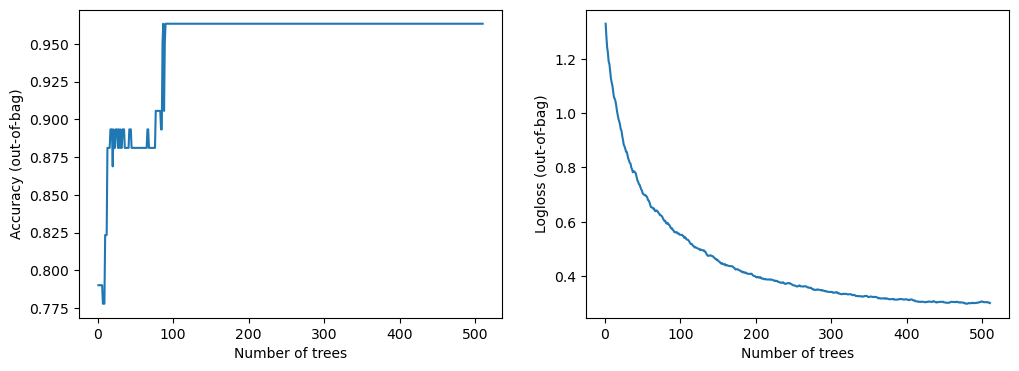


Train: 0.3152 Validation: 0.1534
##### Fold 9
Use /tmp/tmpqy71ysnh as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:51.5644 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:51.5644 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:51.5645 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.255210. Found 556 examples.
Training model...
Model trained in 0:00:00.778634
Compiling model...


[INFO 23-07-29 11:46:53.6009 UTC kernel.cc:1242] Loading model from path /tmp/tmpqy71ysnh/model/ with prefix a2065f1fbf474f77
[INFO 23-07-29 11:46:53.6085 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-29 11:46:53.6085 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_log_loss: 0.3722


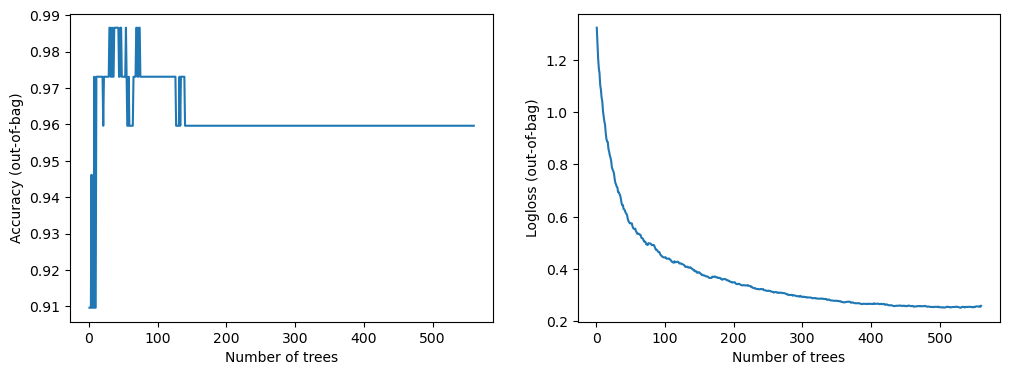


Train: 0.2672 Validation: 0.3722
##### Fold 10
Use /tmp/tmp1vty50ny as temporary training directory
Reading training dataset...


[WARNING 23-07-29 11:46:58.2563 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:58.2564 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-29 11:46:58.2564 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.392964. Found 556 examples.
Training model...
Model trained in 0:00:00.609388
Compiling model...


[INFO 23-07-29 11:47:00.2615 UTC kernel.cc:1242] Loading model from path /tmp/tmp1vty50ny/model/ with prefix 82d08f531a5b4322
[INFO 23-07-29 11:47:00.2683 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9836 - balanced_log_loss: 0.1415


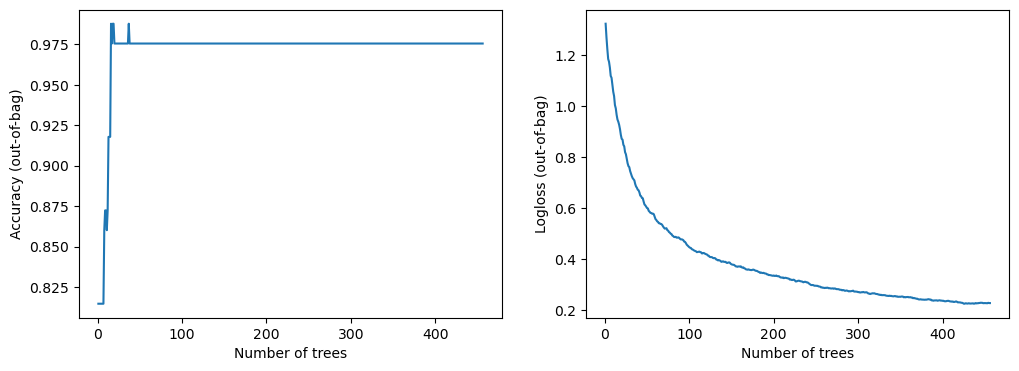


Train: 0.5158 Validation: 0.1415

Train mean: 0.3498 std: 0.1066

Validation mean: 0.2301 std: 0.0742
1/1 [==============================] - 0s 142ms/step


In [14]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=1902)

# initialise
CV_Ensemble_GBT_2 = TFDF_CV_Ensemble(model_obj=tfdf.keras.GradientBoostedTreesModel, label="Class")

# train
CV_Ensemble_GBT_2 = CV_Ensemble_GBT_2.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs=dict(max_depth=2, num_trees=1000),
                                  model_compile_kwargs=dict(metrics=[metrics.binary_accuracy,BalancedLogLoss()]))

# save
CV_Ensemble_GBT_2.save(save_path='/kaggle/working/GBT/2')

# Collect attributes and predictions

train_summary_gbt_2 = CV_Ensemble_GBT_2.X_summary
valid_summary_gbt_2 = CV_Ensemble_GBT_2.valid_summary
test_summary_gbt_2 = CV_Ensemble_GBT_2.predict(X=test_out)
model_gbt_2 = CV_Ensemble_GBT_2.models
metrics_gbt_2 = CV_Ensemble_GBT_2.metrics

# TabPFN

In [15]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    
    # Correct Values
    min_val = 1e-15
    max_val = 0.999999999999999

    y_pred = np.minimum(y_pred, [max_val])
    y_pred = np.maximum(y_pred, [min_val])
    
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

def train_model_tabpfn_one(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    test_summary = pd.DataFrame(data=np.full((len(test.index),1), np.nan),index=test.index)
    train_summary = pd.DataFrame(data=np.full((len(train.index),1), np.nan),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_test = model.predict_proba(test[features])[:,1]

    # Predict value for validation/Submition data
    test_summary[0] = p_test.flatten() 
    train_summary[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
    metrics['balanced_logloss'] = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    print(f"\nTrain: {metrics['balanced_logloss']:.4f}")
    
            
    return train_summary, test_summary, model, metrics

class TabPFN_CV_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, model_obj = TabPFNClassifier, label = "Class"):
        self.label: str = label
        self.model_obj = model_obj
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.valid_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list()
        self.models: dict = dict()
        self.metrics: dict = dict()
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, features: list, splitter = StratifiedKFold(),
            model_kwargs = dict(N_ensemble_configurations=64)):
        
        # Case CV Ensmble
        # TODO: Case of N_ensemble_configurations
        
        n_splits = splitter.get_n_splits()

        # Create a various frames
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan), index=X.index) # For In-Sample Predictions of each Fold
        self.valid_summary = pd.DataFrame(data=np.full((len(X.index),1), np.nan), index=X.index) # For Out-of-Sample Prediction of each Fold
        self.features: list = features
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.models = {}
        self.metrics = {}
        balanced_logloss_train = {}
        balanced_logloss_val = {}

        class_weight: dict = self._compute_weights(X)
        
        for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X[self.label])):
            print('##### Fold',i)
            # Fetch values corresponding to the index 
            train_df = X.iloc[train_index]
            valid_df = X.iloc[valid_index]
            train_ids = train_df.index.values
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[self.features+[self.label]]
            valid_df = valid_df[self.features+[self.label]]

            # Define & Train the model
            model = self.model_obj(**model_kwargs)
            model.fit(train_df[self.features],train_df[self.label])

            # Store the model
            self.models[i] = model

            # Predict value for validation/Submition data
            p_train = model.predict_proba(train_df[self.features])[:,1]
            p_val = model.predict_proba(valid_df[self.features])[:,1]

            # Predict Values
            self.X_summary.loc[train_ids, i] = p_train
            self.valid_summary.loc[valid_ids, 0] = p_val

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[self.label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[self.label].values,y_pred=p_val)

            balanced_logloss_train[i] = train_metric
            balanced_logloss_val[i] = val_metric

            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
        self.metrics['train'] = balanced_logloss_train
        self.metrics['val'] = balanced_logloss_val

        print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
        print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_splits = len(self.models)
        X_summary = pd.DataFrame(data=np.full((len(X.index),n_splits), np.nan),index=X.index) # For X (Sumbition) Predictions of each Fold's Model

        for i, model in enumerate(self.models.values()):
            X_summary[i] = model.predict_proba(X[self.features])[:,1]
        
        return X_summary
    
    def save(self, save_path: str) -> None:
        try:
            shutil.rmtree(save_path)
        except FileNotFoundError:
            pass
        else:
            pass
            
        os.makedirs(f'{save_path}/models', exist_ok=True)
        
        for fold, model in self.models.items():
            joblib.dump(value=model, filename=f'{save_path}/models/{fold}.pickle')
        
        joblib.dump(value=self.label, filename=f'{save_path}/label.pickle')
        joblib.dump(value=self.model_obj, filename=f'{save_path}/model_obj.pickle')
        
        joblib.dump(value=self.X_summary, filename=f'{save_path}/X_summary.pickle')
        joblib.dump(value=self.valid_summary, filename=f'{save_path}/valid_summary.pickle')
        joblib.dump(value=self.features, filename=f'{save_path}/features.pickle')
        joblib.dump(value=self.metrics, filename=f'{save_path}/metrics.pickle')
            
        return None
    
    def load(self, save_path: str):
        
        self.label = joblib.load(filename=f'{save_path}/label.pickle')
        self.model_obj = joblib.load(filename=f'{save_path}/model_obj.pickle')
        
        self.X_summary = joblib.load(filename=f'{save_path}/X_summary.pickle')
        self.valid_summary = joblib.load(filename=f'{save_path}/valid_summary.pickle')
        self.features = joblib.load(filename=f'{save_path}/features.pickle')
        self.metrics = joblib.load(filename=f'{save_path}/metrics.pickle')
        
        self.models = dict()
        
        for name in os.listdir(f'{save_path}/models'):
            i = name.split('.')[0]
            self.models[int(i)] = joblib.load(filename=f'{save_path}/models/{name}')
            
        return self

Before
```python
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,test=test_out, features=features_slice, n_splits=6)
```

In [16]:
%%time
# TabPFN tabpfn_

features_slice = [i for i in features if len(i) > 2]
train_summary_tabpfn_1, test_summary_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
    train=train_out,test=test_out, features=features_slice)

os.makedirs('/kaggle/working/TabPFN/1',exist_ok=True)
joblib.dump(value=model_tabpfn_1, filename='/kaggle/working/TabPFN/1/1.pickle')

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515
CPU times: user 2min 57s, sys: 52.8 s, total: 3min 50s
Wall time: 1min 57s


['/kaggle/working/TabPFN/1/1.pickle']

In [17]:
%%time
# TabPFN
features_slice = [i for i in features if len(i) > 2]

# Test
my_splitter = StratifiedKFold(n_splits=6,shuffle=True, random_state=1902)

# initialise
TabPFN_CV_Ensemble_2 = TabPFN_CV_Ensemble(model_obj = TabPFNClassifier, label = "Class")

# train
TabPFN_CV_Ensemble_2 = TabPFN_CV_Ensemble_2.fit(X=train_out, features=features_slice, 
                                  splitter=my_splitter,
                                  model_kwargs = dict(N_ensemble_configurations=64))

# save
TabPFN_CV_Ensemble_2.save(save_path='/kaggle/working/TabPFN/2')

# Collect attributes and predictions

train_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.X_summary
valid_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.valid_summary
test_summary_tabpfn_2 = TabPFN_CV_Ensemble_2.predict(X=test_out)
model_tabpfn_2 = TabPFN_CV_Ensemble_2.models
metrics_tabpfn_2 = TabPFN_CV_Ensemble_2.metrics

# for inference load

# TabPFN_CV_Ensemble_2_load = TabPFN_CV_Ensemble(model_obj = TabPFNClassifier, label = "Class")

# TabPFN_CV_Ensemble_2_load = TabPFN_CV_Ensemble_2_load.load(save_path='/kaggle/working/TabPFN/2')


# train_summary_tabpfn_2, valid_summary_tabpfn_2, test_summary_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
#     train=train_out,test=test_out, features=features_slice, n_splits=6)

##### Fold 0
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0591 Validation: 0.1325
##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0528 Validation: 0.3273
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0505 Validation: 0.3091
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.2504
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0512 Validation: 0.2377
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0519 Validation: 0.4155

Train mean: 0.0528 std: 0.0032

Validation mean: 0.2788 std: 0.0958
CPU times: user 20min 17s, sys: 5min 40s, total: 25min 58s
Wall time: 13min 12s


# Ensemble CV

Idea to create Entity that can accept multiple previously fitted Regressors and then create final estimate.

In [130]:
class Diff_Class_Ensemble(RegressorMixin,BaseEstimator):
    def __init__(self, label = "Class"):
        self.label: str = label
        
        # Empty
        self.X_summary: pd.DataFrame = pd.DataFrame()
        self.features: list = list() # Shall be Union of all features
        self.models: dict = dict() # Each Feature is a scikit-learn compatible & fitted
        self.metrics: dict = dict()
        self.weights: np.ndarray = None
        
        
    def _compute_weights(self, df: pd.DataFrame) -> dict:
        # Calculate the number of samples for each label.
        neg, pos = np.bincount(df[self.label])
        total = neg + pos
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)
        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        return class_weight
        
    def fit(self, X: pd.DataFrame, 
            models: list, weights: np.ndarray, # List of Estimated Regressors 
            splitter = StratifiedKFold()):
        
        # Count how many sub models we have 
        n_models = len(models)
        self.models = dict()
        self.X_summary = pd.DataFrame(data=np.full((len(X.index),n_models), np.nan), index=X.index) # For In-Sample Predictions of each Fold
     
        # Make Estimations
        for i,model in enumerate(models):
            X_predicted: pd.DataFrame = model.predict(X) # Shall have original features, which would be checked in DF X
            X_predicted: pd.Series = X_predicted.mean(axis=1)
            self.X_summary[i] = X_predicted
            self.models[i] = model
            self.features = self.features + model.features
        
        # To omit duplications
        self.features: list = list(set(self.features))
        
        # Create an empty dictionary to store the models Xed for each fold.
        self.metrics = {}
        
        for weight in weights:
            weight = weight.reshape(2,1)
            
            self.metrics[tuple(weight)] = dict(train=list(),valid=list())
            
            for i, (train_index, valid_index) in enumerate(splitter.split(X=X,y=X[self.label])):
                # Fetch values corresponding to the index 
                train_df: np.ndarray = self.X_summary.iloc[train_index].values
                valid_df: np.ndarray = self.X_summary.iloc[valid_index].values

                # Predict value for validation/Submition data
                p_train = train_df.dot(weight)
                p_val = valid_df.dot(weight)

                y_train_true: pd.Series = X.iloc[train_index][self.label].values
                y_valid_true: pd.Series = X.iloc[valid_index][self.label].values

                # Evaluate and store the metrics in respective dicts
                train_metric = balanced_logloss_np(y_true=y_train_true,y_pred=p_train)
                val_metric = balanced_logloss_np(y_true=y_valid_true,y_pred=p_val)

                self.metrics[tuple(weight)]['train'].append(train_metric)
                self.metrics[tuple(weight)]['valid'].append(val_metric)
            
            self.metrics[list(weight)]['train_mean'] = np.mean(self.metrics[list(weight)]['train'])
            self.metrics[list(weight)]['train_std'] = np.std(self.metrics[list(weight)]['train'])
            self.metrics[list(weight)]['valid_mean'] = np.mean(self.metrics[list(weight)]['valid'])
            self.metrics[list(weight)]['valid_std'] = np.std(self.metrics[list(weight)]['valid'])
            
            # TODO: Some Logic
            self.weights: np.ndarray = weights[0,:].reshape(-1,1)
            
        return self
    
    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        n_models = len(self.models)
        Y_Preds = pd.DataFrame(data=np.full((len(X.index),n_models), np.nan),
                               index=X.index)

        for i, model in enumerate(self.models.values()):
            Y_Preds[i] = model.predict(X).mean(axis=1)
            
        Y_Preds: np.ndarray = Y_Preds.values
        
        y_pred = Y_Preds.dot(self.weights)
        
        return y_pred

# Initialise

Diff_Class_Ensemble_3Class = Diff_Class_Ensemble(label='Class')

# Fit 
my_splitter = StratifiedKFold(n_splits=3,shuffle=True, random_state=19960219)

my_weights = np.array([[0.1,0.9],
                       [0.2,0.8],
                       [0.3,0.7],
                       [0.4,0.6]])

Diff_Class_Ensemble_3Class = Diff_Class_Ensemble_3Class.fit(X=train_out,
                                                            models = [CV_Ensemble_GBT_2, CV_Ensemble_3], 
                                                            splitter = my_splitter,
                                                            weights = my_weights)

ensemble_final_test_out = Diff_Class_Ensemble_3Class.predict(X=test_out)

ensemble_final_test_out

1/1 [==============================] - 0s 203ms/step


TypeError: unhashable type: 'list'

In [129]:
my_weights[0,:].reshape(-1,1)

array([[0.1],
       [0.9]])

In [115]:
np.array([[0.6,0.5],
          [0.4,0.5]])

array([[0.6, 0.5],
       [0.4, 0.5]])

In [87]:
y_preds = ensemble_final_test_out.values

y_preds

array([[0.62424546, 0.36366636],
       [0.62424546, 0.36366636],
       [0.62424546, 0.36366636],
       [0.62424546, 0.36366636],
       [0.62424546, 0.36366636]], dtype=float32)

In [120]:
my_weights.shape

(2, 9)

In [124]:
for i in my_weights:
    print(list(i))

[0.1, 0.9]
[0.2, 0.8]
[0.3, 0.7]
[0.4, 0.6]


In [93]:
type(manual_weights)

numpy.ndarray

In [103]:
manual_weights = np.array([[0.6],[0.4]]) # like=(2,1))#.reshape(2,1)
manual_weights.shape

(2, 1)

In [102]:
manual_weights

array([[0.6],
       [0.4]])

In [92]:
y_preds.dot(manual_weights)

array([[0.52001382],
       [0.52001382],
       [0.52001382],
       [0.52001382],
       [0.52001382]])

In [81]:
# We need to find optimal linear combination
tmp = train_summary_gbt_2.fillna(0)

tmp['Class'] = train_out['Class']

from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression

tmp_model =  LinearRegression(n_jobs=1, normalize=True)

tmp_model = tmp_model.fit(X=tmp.iloc[:,:10].values, y=tmp.iloc[:,10].values)

tmp_model.coef_

TypeError: LinearRegression.__init__() got an unexpected keyword argument 'normalize'

In [ ]:
from sklearn.decomposition import PCA



In [ ]:
class EnsembleCV(object):
    def __init__(self):
        self.is_fitted = False
        self.weights = None
        return
    
    def fit(self, X: pd.DataFrame) -> None:
        self.weights = None
        return
    
    @staticmethod
    def predict(X: pd.DataFrame) -> pd.Series:
        # Take conservative estimate
        X_ = X.mean(axis=1) #.to_frame()
        # Fillna by 1
        X_ = X_.fillna(1)
        return X_

In [ ]:
rf_ensemble = EnsembleCV()
gbt_ensemble = EnsembleCV()
tabpfn_ensemble = EnsembleCV()

test_rf_ensemble = rf_ensemble.predict(X=test_summary_rf_3)
test_gbt_ensemble = gbt_ensemble.predict(X=test_summary_gbt_2)
test_tabpfn_ensemble = tabpfn_ensemble.predict(X=test_summary_tabpfn_1)

In [ ]:
train_out['Class_RF'] = rf_ensemble.predict(X=train_summary_rf_3)
test_out['Class_RF'] = rf_ensemble.predict(X=test_summary_rf_3)

print(pd.Series(metrics_rf_3['train']).mean())
print(pd.Series(metrics_rf_3['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_RF'].values))

In [ ]:
train_out['Class_GBT'] = gbt_ensemble.predict(X=train_summary_gbt_2)
test_out['Class_GBT'] = gbt_ensemble.predict(X=test_summary_gbt_2)

print(pd.Series(metrics_gbt_2['train']).mean())
print(pd.Series(metrics_gbt_2['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_GBT'].values))

In [ ]:
train_out['Class_TABPFN'] = tabpfn_ensemble.predict(X=train_summary_tabpfn_1)
test_out['Class_TABPFN'] = tabpfn_ensemble.predict(X=test_summary_tabpfn_1)

print(pd.Series(metrics_tabpfn_2['train']).mean())
print(pd.Series(metrics_tabpfn_2['val']).mean())
print(balanced_logloss_np(y_true=train_out['Class'].values,y_pred=train_out['Class_TABPFN'].values))

# Ensemble Classes

I can for example use GBT

In [ ]:
train_out[['Class_RF','Class_GBT','Class_TABPFN','Class']].corr()

In [ ]:
# GradientBoostedTreesModel
# Got Very Bas score up to 1.5 in LB
# train_summary_gbt_3, valid_summary_gbt_3, test_summary_gbt_3, model_gbt_3,metrics_gbt_3 = train_model(
#     train=train_out,test=test_out, features=['Class_RF','Class_GBT','Class_TABPFN'],                                             
#     n_splits=10,                    
#     model_obj=tfdf.keras.GradientBoostedTreesModel,            
#     model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
#     model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, BalancedLogLoss()]))

In [ ]:
RF_w = 2.5/10
GBT_w = 4.5/10
TabPFN_w = 3./10

print('RF weight: ', RF_w)
print('GBT weight: ', GBT_w)
print('TabPFN weight: ', TabPFN_w)

submition_total = test_out[['Class_RF','Class_GBT','Class_TABPFN']].copy()
submition_total.columns = ['RF','GBT','TabPFN']

submition_total['Ensemble'] = RF_w*submition_total['RF'] + GBT_w*submition_total['GBT'] + TabPFN_w*submition_total['TabPFN']

submition_total.head()

# Submission

In [ ]:
# submition_total
submition_total['Ensemble'] = np.where(submition_total['Ensemble']>0.95,1,submition_total['Ensemble'])
submition_total['Ensemble'] = np.where(submition_total['Ensemble']<0.05,0,submition_total['Ensemble'])
submition_total['class_1'] = submition_total['Ensemble']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']].copy()
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [ ]:
submition_total.head()

In [ ]:
submition_total.info()